# Home Credit Scorecard Model
**Name** : Azarya Yehezkiel Pinondang Sipahutar <br><br>
**Project Goal** : To develop a scorecard model to predict the probability of a customer to default on a loan. <br><br>
**Project Objective** : 

Pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar yang akan memotivasi pelanggan untuk sukses

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

## Load Data

In [3]:
# original data
app_train = pd.read_csv('./data/application_train.csv')
app_test = pd.read_csv('./data/application_test.csv')
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
ccb = pd.read_csv('./data/credit_card_balance.csv')
ip = pd.read_csv('./data/installments_payments.csv')
pb = pd.read_csv('./data/POS_CASH_balance.csv')
pa = pd.read_csv('./data/previous_application.csv')


# sample data
train_sample = app_train.sample(frac=0.05,random_state=7)
test_sample = app_test.sample(frac=0.05,random_state=7)
bureau_sample = bureau.sample(frac=0.05,random_state=7)
bb_sample = bureau_balance.sample(frac=0.05,random_state=7)    
ccb_sample = ccb.sample(frac=0.05,random_state=7)
ip_sample = ip.sample(frac=0.05,random_state=7)
pb_sample = pb.sample(frac=0.05,random_state=7)
pa_sample = pa.sample(frac=0.05,random_state=7)

In [4]:
pd.set_option('display.max_columns', None)

## Initial Data Processing
This Section for better analysis and understanding of the data in the future.

In [5]:
# function to drop columns with missing values
def dropna(df, threshold=0.45):
    '''
    Drop columns from a DataFrame where the proprortion of missing values is greater than specified threshold.

    Parameters:
    df: The DataFrame to process
    threshold: The threshold proportion of missing vales. Columns with a proportion of missing values greater than this will be dropped.

    Returns:
    Pandas.DataFrame: The processed DataFrame. 
    '''
    for column in df.columns:
        missing_proportion = df[column].isnull().sum() / len(df)
        if missing_proportion > threshold:
            df = df.drop(column, axis=1)
    return df

# function to plot missing value percentage
def plot_missing_percentage(df):
    """
    Plot the percentage of missing values for each column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    """
    # Calculate the percentage of missing values
    missing = df.isnull().sum() * 100 / len(df)

    # Create a DataFrame with the results
    percentage_missing = pd.DataFrame({'column': df.columns, 'missing_percentage %': missing.values})
    percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
    percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
    percentage_missing = percentage_missing.reset_index()
    percentage_missing = percentage_missing.drop('index', axis=1)

    # Plot the results
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(x='missing_percentage %', y='column', data=percentage_missing, color='#E1341E')
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_width() + '%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
                    xytext=(8, 0), textcoords='offset points', ha="left", va="center", fontsize=10)
    plt.title('Missing values Percentage for Each Column', fontsize=17, fontweight='bold')
    plt.ylabel('Kolom', fontsize=12)
    plt.xlabel('missing_percentage %', fontsize=12)
    plt.tight_layout()
    plt.xlim(0, 100)
    plt.show()

In [6]:
# merge the data
bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bb'))

train_bureau = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))
test_bureau = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))

# merge previous applications
pa_pos = pd.merge(pa_sample, pb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_pb'))
pa_cb = pd.merge(pa_pos, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb', '_ccb'))
pa_full = pd.merge(pa_cb, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb_ccb', '_ip'))
pa_full.rename(columns={'SK_ID_CURR_pa': 'SK_ID_CURR'}, inplace=True)

train_full = pd.merge(train_bureau, pa_full, on='SK_ID_CURR', how='inner', suffixes=('_CURR', '_PREV'))
test_full = pd.merge(test_bureau, pa_full, on='SK_ID_CURR', how='inner', suffixes=('_CURR', '_PREV'))

# Drop the right dataframe's columns
train_full = train_full[train_full.columns.drop(list(train_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]
test_full = test_full[test_full.columns.drop(list(test_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]

print(train_full.shape)
print(test_full.shape)

(5690, 201)
(1257, 200)


In [7]:
# Create a list of dataframes to clean
df2clean = [train_full, test_full]

# Loop through the list and clean each dataframe by dropping NA values
for i, df in enumerate(df2clean):
    df2clean[i] = dropna(df)

# Unpack the cleaned dataframes back into their original variables
train_full, test_full = df2clean

# Get a list of column names from the train dataframe, excluding the 'TARGET' column
traincol = train_full.drop('TARGET', axis=1).columns

# Restrict the columns in the test dataframe to match those in the train dataframe
test_full = test_full[traincol]

# Print the shape of the dataframes to check the number of rows and columns
print(train_full.shape)
print(test_full.shape)

(5690, 104)
(1257, 103)


train data: 
(5690, 104)


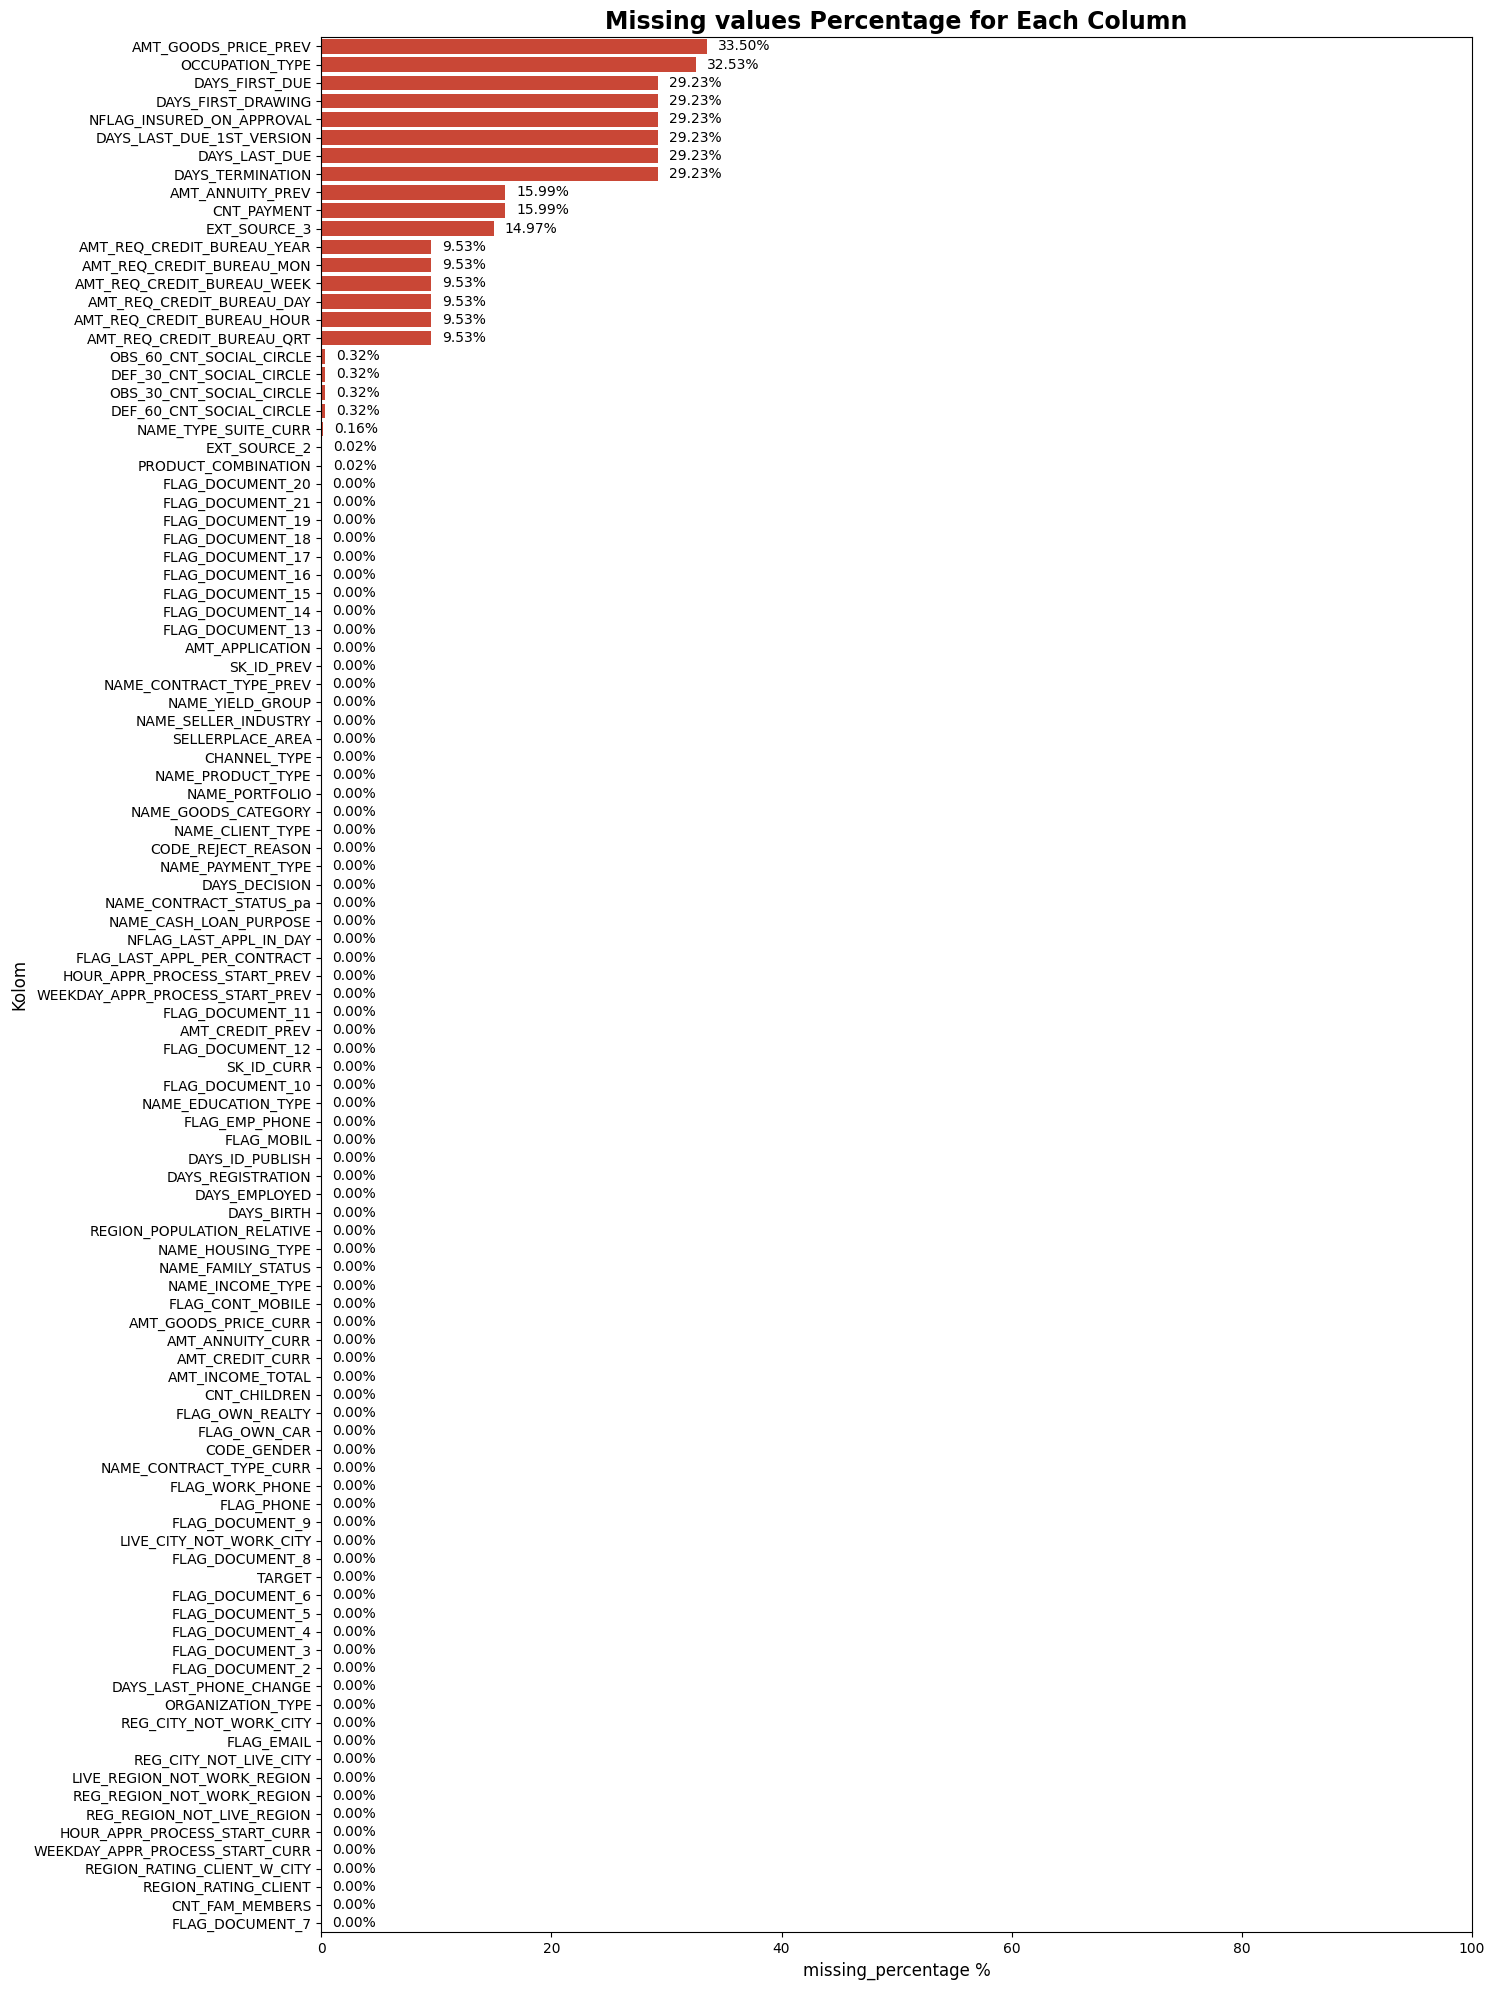

None

test data: 
(1257, 103)


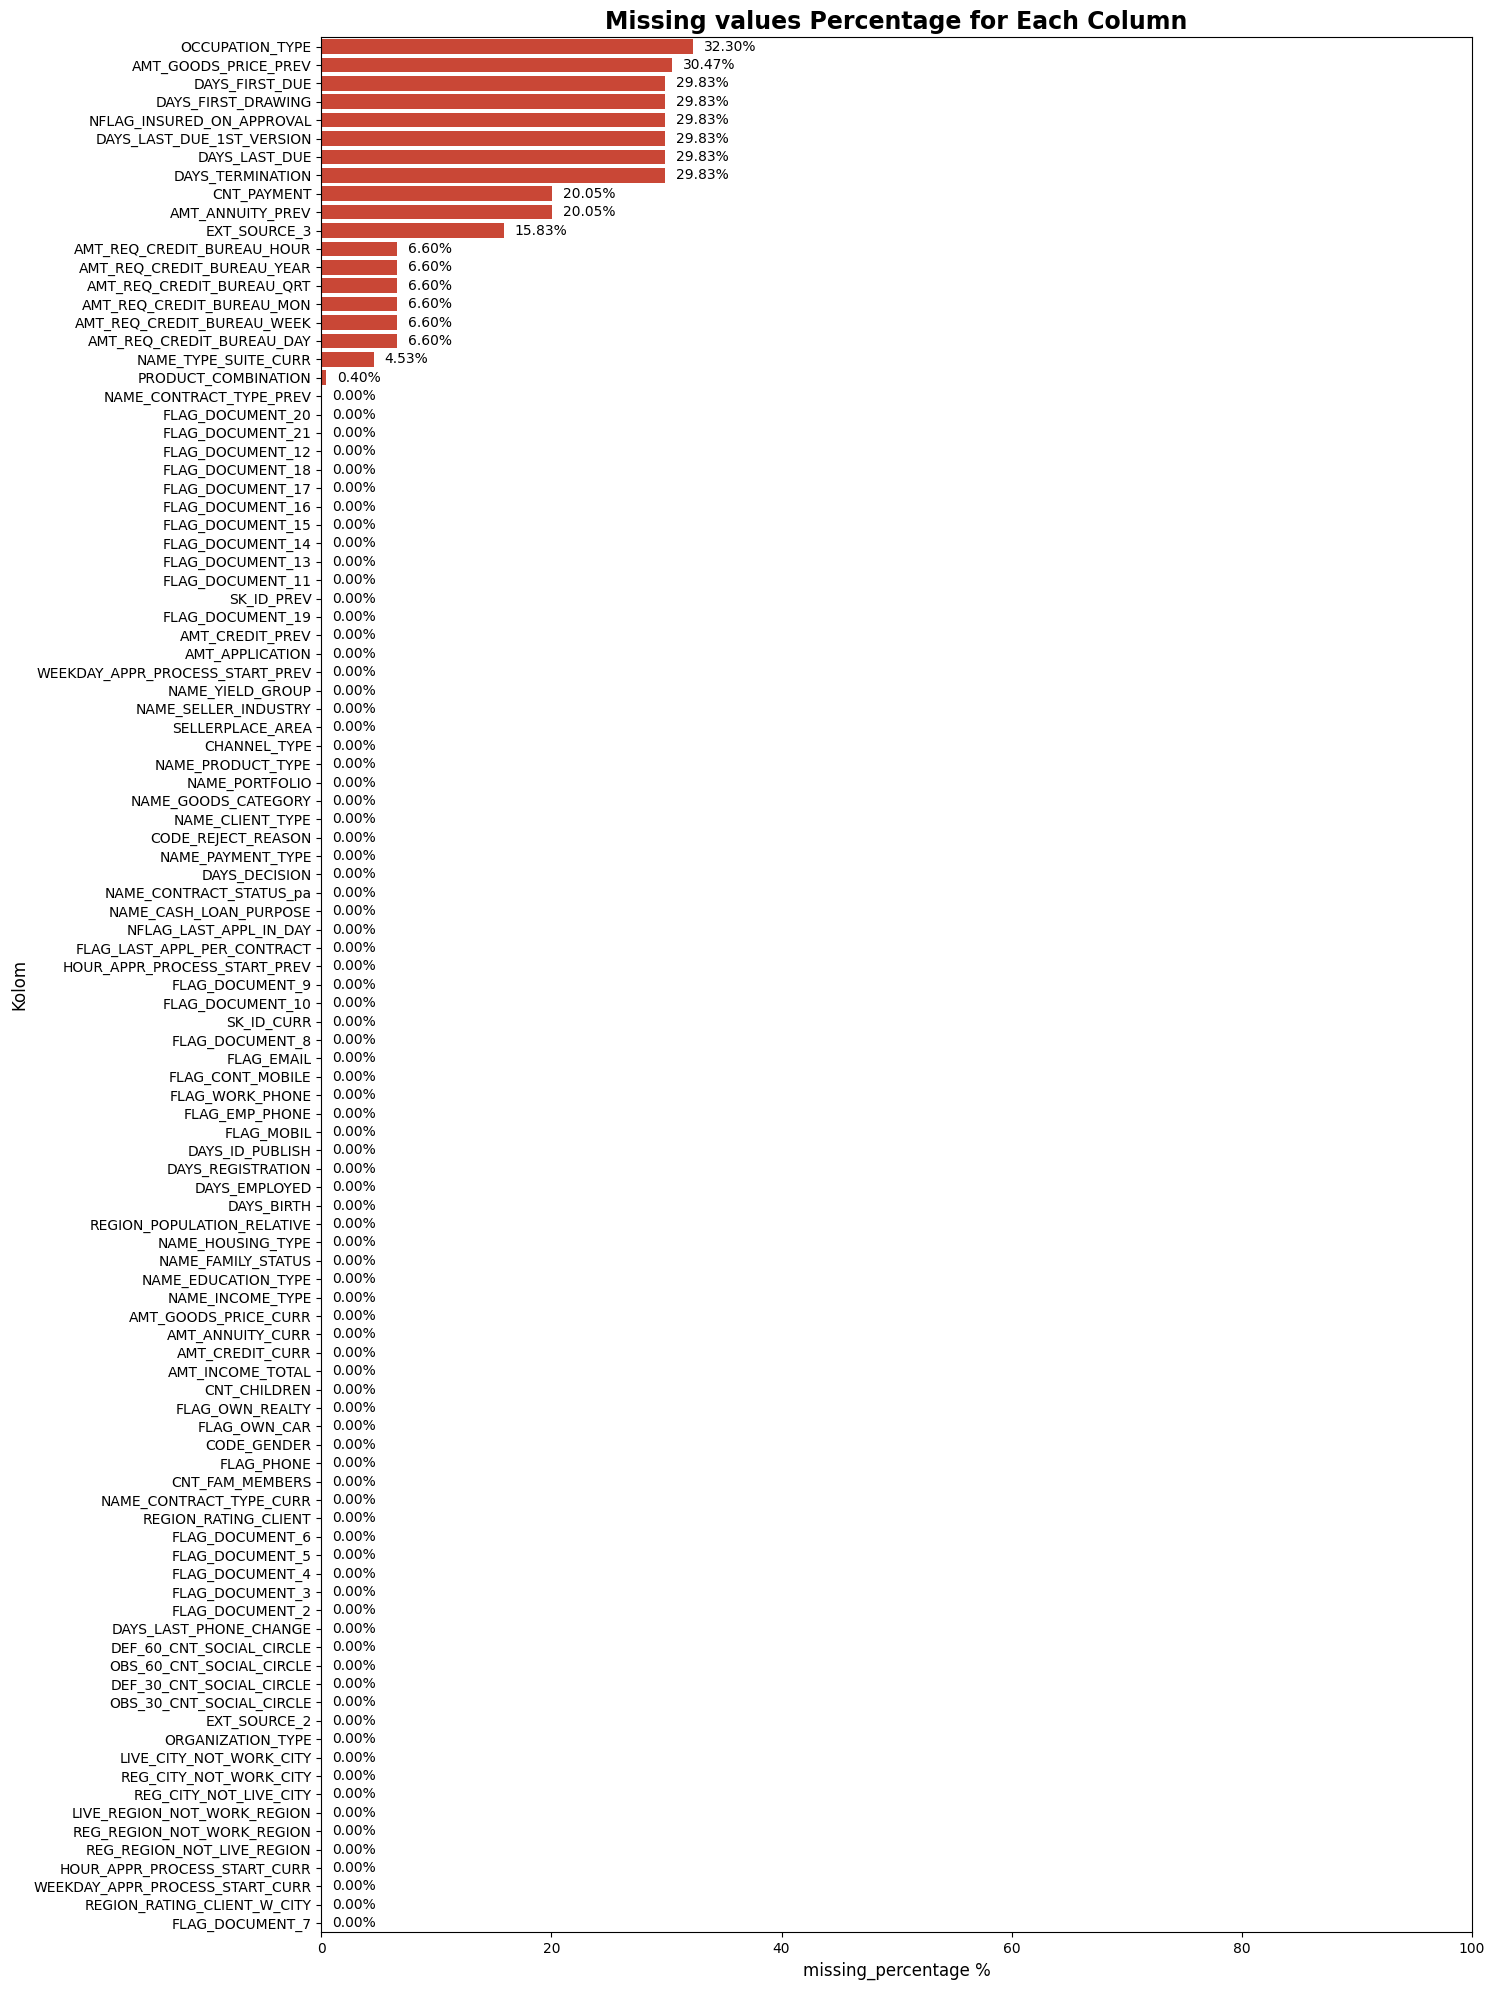

None

In [8]:
train_full = dropna(train_full)
print(f'train data: \n{train_full.shape}')
display(plot_missing_percentage(train_full))

test_full = dropna(test_full)
print(f'test data: \n{test_full.shape}')
display(plot_missing_percentage(test_full))

In [9]:
# copy train test data for processing
tc = train_full.copy()
tsc = test_full.copy()

# add features for better interpretation analysis
tc['AGE'] = round(abs(tc['DAYS_BIRTH'] / 365.25)).astype(int)
tsc['AGE'] = round(abs(tsc['DAYS_BIRTH'] / 365.25)).astype(int)

age_group = [
    (tc['AGE'] > 20) & (tc['AGE'] < 30),
    (tc['AGE'] >= 30) & (tc['AGE'] < 40),
    (tc['AGE'] >= 40) & (tc['AGE'] < 50),
    (tc['AGE'] >= 50) & (tc['AGE'] < 60),
    tc['AGE'] >= 60
]
age_labels = ['Twenty', 'Thirty', 'Forty', 'Fifty', 'Sixty and above']
tc['AGE_GROUP'] = np.select(age_group, age_labels)

age_group = [
    (tsc['AGE'] > 20) & (tsc['AGE'] < 30),
    (tsc['AGE'] >= 30) & (tsc['AGE'] < 40),
    (tsc['AGE'] >= 40) & (tsc['AGE'] < 50),
    (tsc['AGE'] >= 50) & (tsc['AGE'] < 60),
    tsc['AGE'] >= 60
]
tsc['AGE_GROUP'] = np.select(age_group, age_labels)

# days deecision
tc['DAYS_DECISION'] = abs(tc['DAYS_DECISION'])
tsc['DAYS_DECISION'] = abs(tsc['DAYS_DECISION'])
tc['MONTHS_DECISION'] = round(tc['DAYS_DECISION'] / 30).astype(int)
tsc['MONTHS_DECISION'] = round(tsc['DAYS_DECISION'] / 30).astype(int)

months_group = [
    (tc['MONTHS_DECISION'] >= 0) & (tc['MONTHS_DECISION'] < 12),
    (tc['MONTHS_DECISION'] >= 12) & (tc['MONTHS_DECISION'] < 24),
    (tc['MONTHS_DECISION'] >= 24) & (tc['MONTHS_DECISION'] < 36),
    (tc['MONTHS_DECISION'] >= 36) & (tc['MONTHS_DECISION'] < 48),
    (tc['MONTHS_DECISION'] >= 48) & (tc['MONTHS_DECISION'] < 60),
    tc['MONTHS_DECISION'] >= 60
]
year_labels = ['One Yr', 'Two Yrs', 'Three Yrs', 'Four Yrs', 'Five Yrs', 'Six Yrs and above']
tc['YEAR_DECISION'] = np.select(months_group, year_labels)

months_group = [
    (tsc['MONTHS_DECISION'] >= 0) & (tsc['MONTHS_DECISION'] < 12),
    (tsc['MONTHS_DECISION'] >= 12) & (tsc['MONTHS_DECISION'] < 24),
    (tsc['MONTHS_DECISION'] >= 24) & (tsc['MONTHS_DECISION'] < 36),
    (tsc['MONTHS_DECISION'] >= 36) & (tsc['MONTHS_DECISION'] < 48),
    (tsc['MONTHS_DECISION'] >= 48) & (tsc['MONTHS_DECISION'] < 60),
    tsc['MONTHS_DECISION'] >= 60
]
tsc['YEAR_DECISION'] = np.select(months_group, year_labels)


# days employed
tc['DAYS_EMPLOYED'] = abs(tc['DAYS_EMPLOYED'])
tsc['DAYS_EMPLOYED'] = abs(tsc['DAYS_EMPLOYED'])

# days registration
tc['DAYS_REGISTRATION'] = abs(tc['DAYS_REGISTRATION'])
tsc['DAYS_REGISTRATION'] = abs(tsc['DAYS_REGISTRATION'])

# days id publish
tc['DAYS_ID_PUBLISH'] = abs(tc['DAYS_ID_PUBLISH'])
tsc['DAYS_ID_PUBLISH'] = abs(tsc['DAYS_ID_PUBLISH'])

# days first draw
tc['DAYS_FIRST_DRAWING'] = abs(tc['DAYS_FIRST_DRAWING'])
tsc['DAYS_FIRST_DRAWING'] = abs(tsc['DAYS_FIRST_DRAWING'])

# days first due
tc['DAYS_FIRST_DUE'] = abs(tc['DAYS_FIRST_DUE'])
tsc['DAYS_FIRST_DUE'] = abs(tsc['DAYS_FIRST_DUE'])

# days last due
tc['DAYS_LAST_DUE'] = abs(tc['DAYS_LAST_DUE'])
tsc['DAYS_LAST_DUE'] = abs(tsc['DAYS_LAST_DUE'])

# days last due 1st version
tc['DAYS_LAST_DUE_1ST_VERSION'] = abs(tc['DAYS_LAST_DUE_1ST_VERSION'])
tsc['DAYS_LAST_DUE_1ST_VERSION'] = abs(tsc['DAYS_LAST_DUE_1ST_VERSION'])

# days termination
tc['DAYS_TERMINATION'] = abs(tc['DAYS_TERMINATION'])
tsc['DAYS_TERMINATION'] = abs(tsc['DAYS_TERMINATION'])


# rrp_group = [
#     (tc['REGION_POPULATION_RELATIVE'] > 0) & (tc['REGION_POPULATION_RELATIVE'] < 0.011),
#     (tc['REGION_POPULATION_RELATIVE'] >= 0.011) & (tc['REGION_POPULATION_RELATIVE'] < 0.021),
#     (tc['REGION_POPULATION_RELATIVE'] >= 0.022) & (tc['REGION_POPULATION_RELATIVE'] < 0.031),
#     (tc['REGION_POPULATION_RELATIVE'] >= 0.031) & (tc['REGION_POPULATION_RELATIVE'] < 0.041),
#     (tc['REGION_POPULATION_RELATIVE'] >= 0.041) & (tc['REGION_POPULATION_RELATIVE'] < 0.051),
#     tc['REGION_POPULATION_RELATIVE'] >= 0.051
# ]

rrp_group = [
    (tc['REGION_POPULATION_RELATIVE'] > 0.0) & (tc['REGION_POPULATION_RELATIVE'] < 0.020),
    (tc['REGION_POPULATION_RELATIVE'] >= 0.020) & (tc['REGION_POPULATION_RELATIVE'] < 0.04),
    tc['REGION_POPULATION_RELATIVE'] >= 0.04
]
rrp_labels = ['Low Populated', 'Medium Populated', 'Highly Populated']
tc['REGION_POPULATION_GROUP'] = np.select(rrp_group, rrp_labels)

rrp_group = [
    (tsc['REGION_POPULATION_RELATIVE'] > 0) & (tsc['REGION_POPULATION_RELATIVE'] < 0.020),
    (tsc['REGION_POPULATION_RELATIVE'] >= 0.020) & (tsc['REGION_POPULATION_RELATIVE'] < 0.04),
    tsc['REGION_POPULATION_RELATIVE'] >= 0.04
]
tsc['REGION_POPULATION_GROUP'] = np.select(rrp_group, rrp_labels)


## EDA

Find the characteristic of clients with no payment difficulties

In [10]:
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5690 entries, 0 to 5689
Columns: 109 entries, SK_ID_CURR to REGION_POPULATION_GROUP
dtypes: float64(31), int32(2), int64(46), object(30)
memory usage: 4.7+ MB


In [11]:
num = tc.select_dtypes(include=['int64', 'float64'])
ctg = tc.select_dtypes(include='object')

# show numerical data statistics
print('Numerical data statistics:')
display(num.describe())

# show categorical data statistics
print('\nCategorical data statistics')
display(ctg.describe())

Numerical data statistics:


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_CURR,AMT_ANNUITY_CURR,AMT_GOODS_PRICE_CURR,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_CURR,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION,AMT_CREDIT_PREV,AMT_GOODS_PRICE_PREV,HOUR_APPR_PROCESS_START_PREV,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,5690.000000,5690.000000,5690.000000,5690.000000,5.690000e+03,5690.000000,5.690000e+03,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5690.000000,5689.000000,4838.000000,5672.000000,5672.000000,5672.000000,5672.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.0,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5690.0,5690.000000,5690.000000,5690.000000,5690.000000,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000,5148.000000,5.690000e+03,4780.000000,5.690000e+03,5.690000e+03,3.784000e+03,5690.000000,5690.000000,5690.000000,5690.000000,4780.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,272098.559227,0.084359,0.390685,174259.505009,5.986221e+05,27715.919156,5.370500e+05,0.020144,-16662.093849,79473.830931,5476.473286,3149.857645,1.0,0.787873,0.177153,0.999649,0.279613,0.086467,2.128647,2.068893,2.036731,12.113357,0.008436,0.037961,0.033919,0.082074,0.199824,0.150088,0.520562,0.491513,1.516396,0.143688,1.494358,0.102433,-1165.901406,0.0,0.760984,0.000176,0.013708,0.105624,0.0,0.057469,0.002460,0.0,0.000703,0.0,0.000527,0.000527,0.000351,0.006151,0.0,0.004042,0.001582,0.000176,0.000176,0.004468,0.009130,0.025641,0.364025,0.319736,2.890831,1.922731e+06,14608.244542,1.570674e+05,2.045811e+05,2.361822e+05,12.363445,0.997540,1155.832337,279.317575,13.830544,262969.075490,10874.063571,110966.221008,79766.229203,121135.152719,0.259995
std,103378.208124,0.277949,0.705116,86861.611908,3.770666e+05,14076.098437,3.466316e+05,0.012377,4183.912174,148309.001276,3685.045825,1512.230948,0.0,0.408850,0.381832,0.018747,0.448849,0.281078,0.892719,0.474891,0.468243,3.099677,0.091467,0.191120,0.181037,0.274501,0.399903,0.357189,0.184830,0.194783,2.454110,0.435162,2.412636,0.353706,817.891770,0.0,0.426520,0.013257,0.116287,0.307383,0.0,0.232757,0.049546,0.0,0.026507,0.0,0.022958,0.022958,0.018747,0.078195,0.0,0.063455,0.039743,0.013257,0.013257,0.066698,0.095122,0.169924,1.124278,0.681960,2.135249,5.266288e+05,14391.769666,2.801547e+05,2.990767e+05,3.151831e+05,3.313003,0.049546,918.705566,952.611761,14.909764,163376.048969,57996.356952,167361.514221,149882.699225,171348.236600,0.438686
min,100073.000000,0.000000,0.000000,27000.000000,4.500000e+04,2164.500000,4.500000e+04,0.001276,-25081.000000,4.000000,0.000000,1.00


Categorical data statistics


,NAME_CONTRACT_TYPE_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE_CURR,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START_CURR,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_PREV,WEEKDAY_APPR_PROCESS_START_PREV,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_pa,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,AGE_GROUP,YEAR_DECISION,REGION_POPULATION_GROUP
count,5690,5690,5690,5690,5681,5690,5690,5690,5690,3839,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5690,5689,5690,5690,5690
unique,2,2,2,2,7,4,5,5,6,18,7,53,4,7,2,18,4,4,8,4,21,5,3,8,10,5,17,5,6,3
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Cash loans,FRIDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Card Street,Forty,Six Yrs and above,Low Populated
freq,5378,3983,3933,4240,4589,2835,4229,3656,5181,1100,1033,1295,2166,929,5674,3524,4147,3029,4918,4303,3614,1999,2922,2224,2734,2250,870,1561,1584,3158


From the categorical variables, we can see that:
- The data contains valid categorical variables, as indicated by the presence of more than one unique value in these categories.
- The most common type of contract our clients have is a cash contract.
- The majority of our clients are female.
- Most of our clients do not own a car.
- Most of our clients own real estate property.
- When applying for a loan, most of our clients do not have a co-applicant or guarantor.
- The most common income type among our clients is salaried or working class.
- The highest level of education most of our clients have achieved is secondary or special secondary education.
- Most of our clients are married.
- The most common type of housing our clients live in is a house or an apartment.
- The most common occupation type among our clients is laborers.
- Wednesday is the most common day for our clients to apply for loans.
- The most common type of organization our clients are associated with is Business Entity Type 3.
- For previous loan applications, the majority of our clients also applied for cash loans.
- The majority of our clients' contracts were approved.
- Most of our clients prefer to make their payments in cash through the bank.
- The most common reason for the previous application is XAP, which means the reason was not specified.
- Most of our clients are repeat customers.
- The majority of our clients' applications are for Point Of Sales (POS).

### 1. Target Distribution

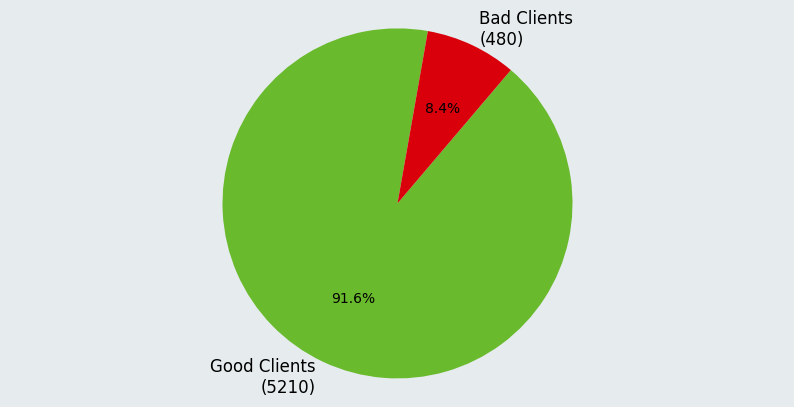

In [12]:
counts = tc['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()

As we can see that Clients in our data is Dominated by Good Clients whose don't have payment difficulties. This also mean that our data class is imbalance, we have to handle this imbalance data later on.

### Outliers Checking

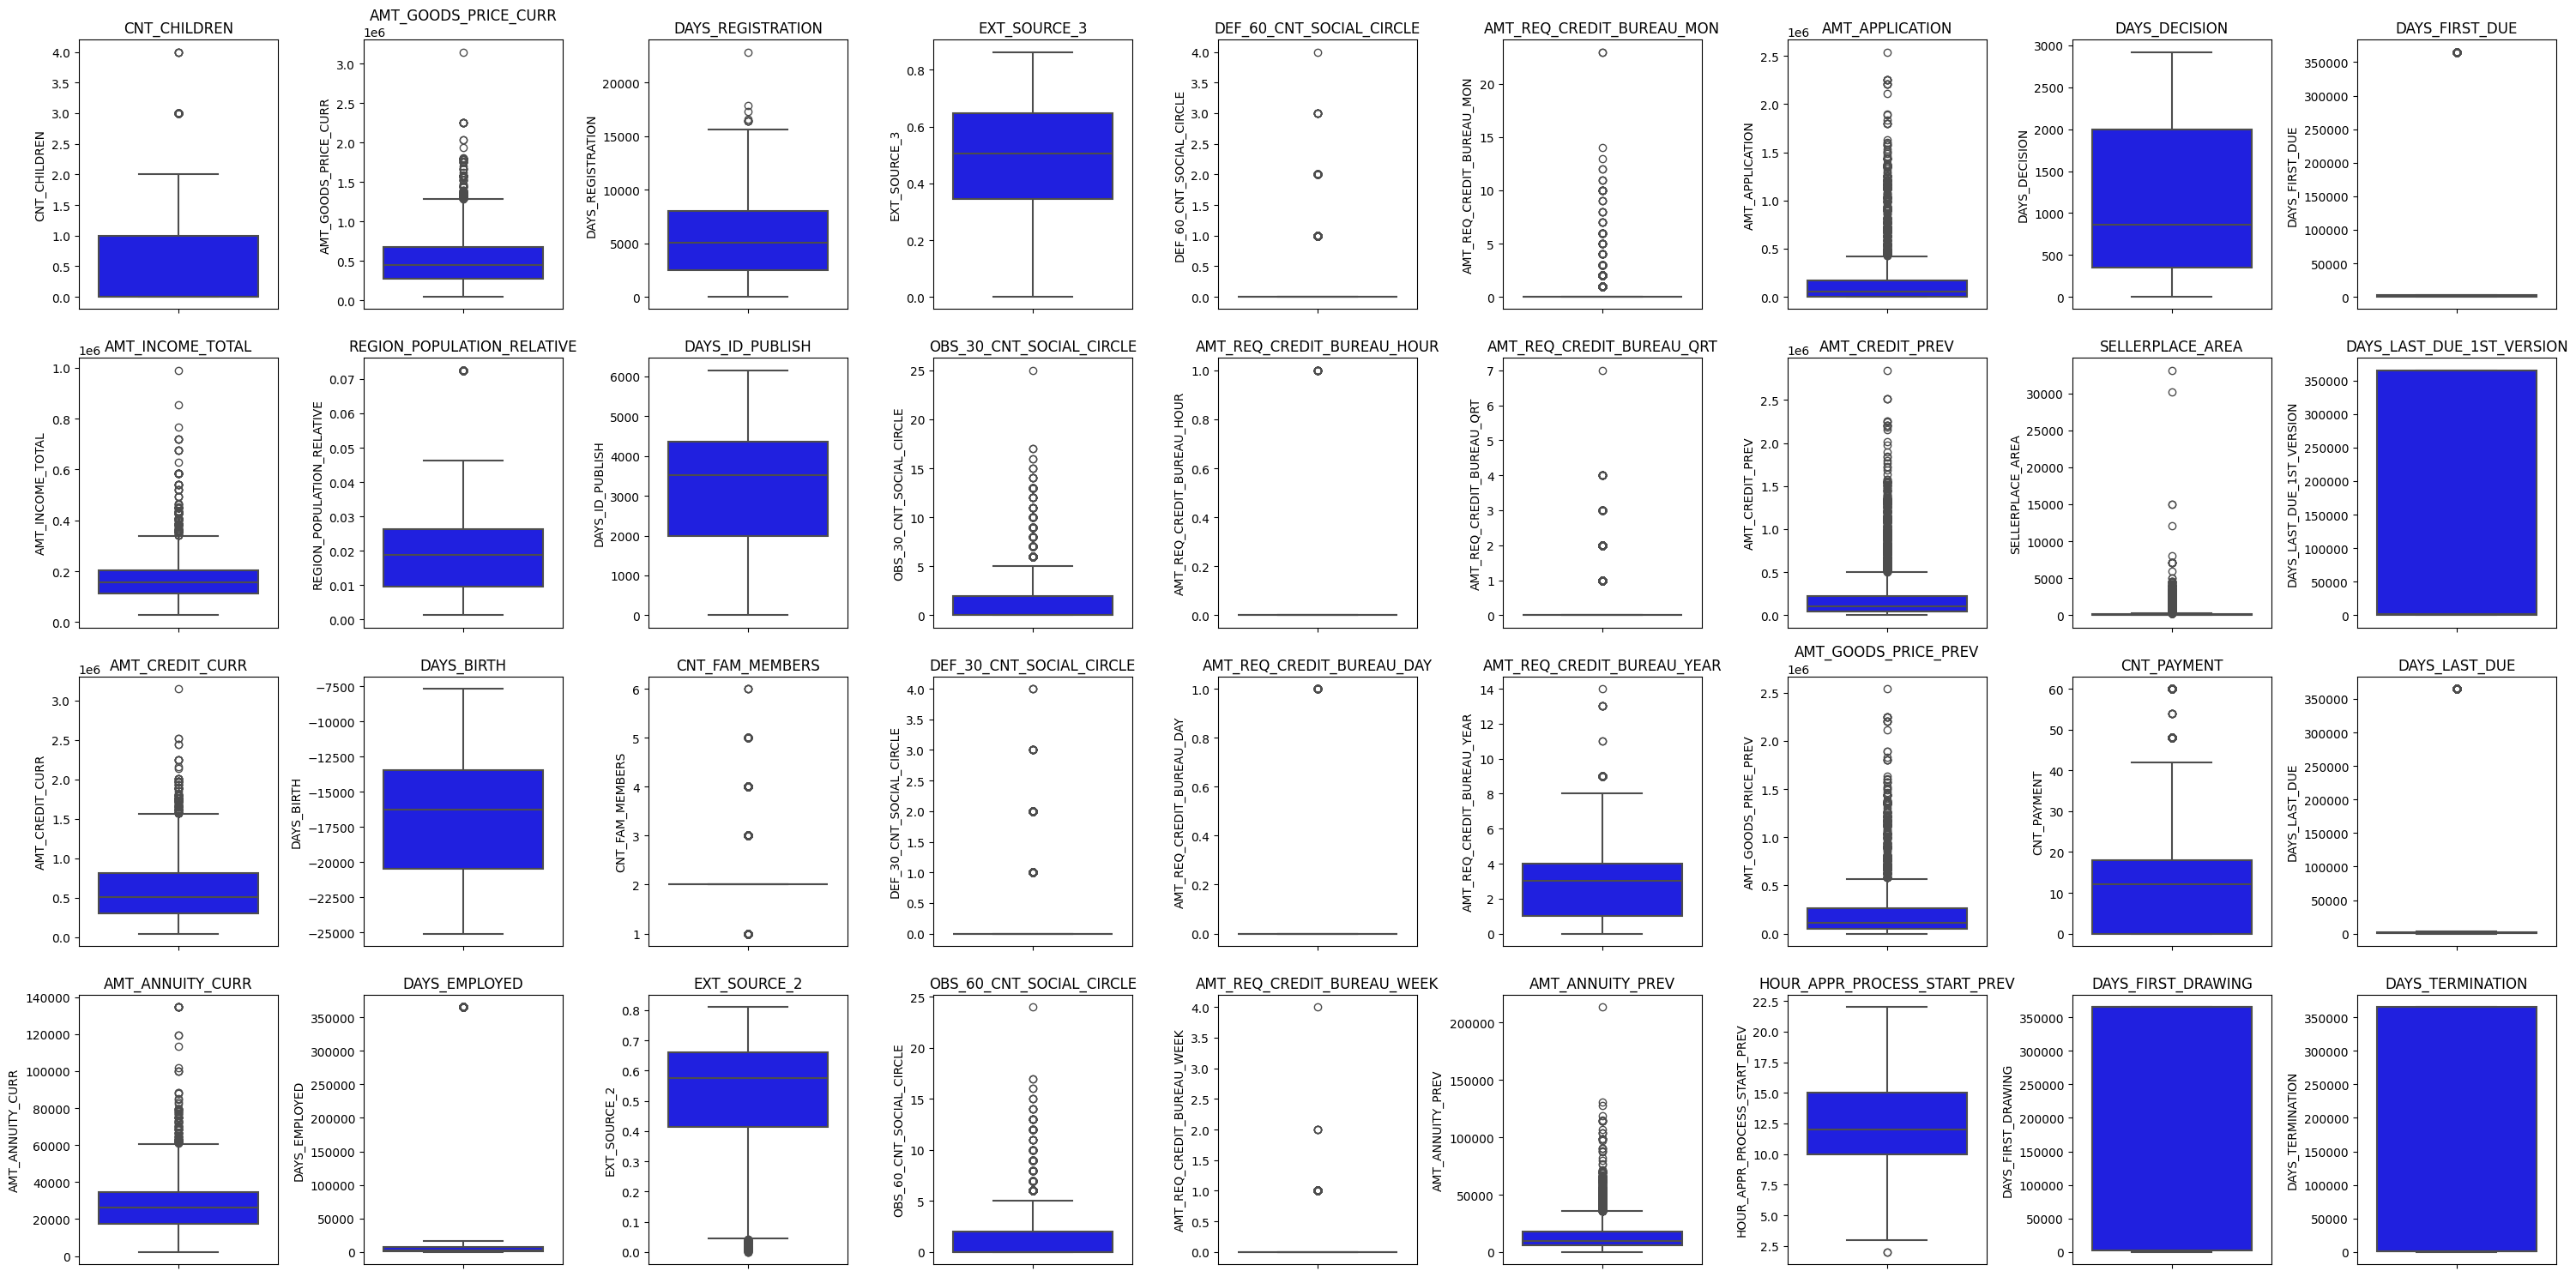

In [13]:
numfx = num[['CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_CURR', 'AMT_ANNUITY_CURR', 
          'AMT_GOODS_PRICE_CURR','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
          'DAYS_REGISTRATION','DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
          'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
          'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
          'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_ANNUITY_PREV', 'AMT_APPLICATION', 'AMT_CREDIT_PREV',
          'AMT_GOODS_PRICE_PREV', 'HOUR_APPR_PROCESS_START_PREV', 'DAYS_DECISION', 'SELLERPLACE_AREA',
          'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION', 
          'DAYS_LAST_DUE', 'DAYS_TERMINATION'
          ]].copy()

colgroup = [numfx.columns[n:n+4] for n in range(0, len(numfx.columns), 4)]

# Create a 9x4 grid of subplots
fig, axs = plt.subplots(4, 9, figsize=(30, 15))

# for each group of 4 columns
for i, group in enumerate(colgroup):
    # For eachg column in the group
    for j, column in enumerate(group):
        # Create a boxplot for the apporopriate subplot
        sns.boxplot(y=numfx[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
        axs[j, i].set_title(column)

# show plot
plt.tight_layout()
plt.show()

### Numerical Features Distribution/Skewness Checking
For the Distribution/Skewness Checking of the numerical features we only focus on some necessary features that we think it's important. 

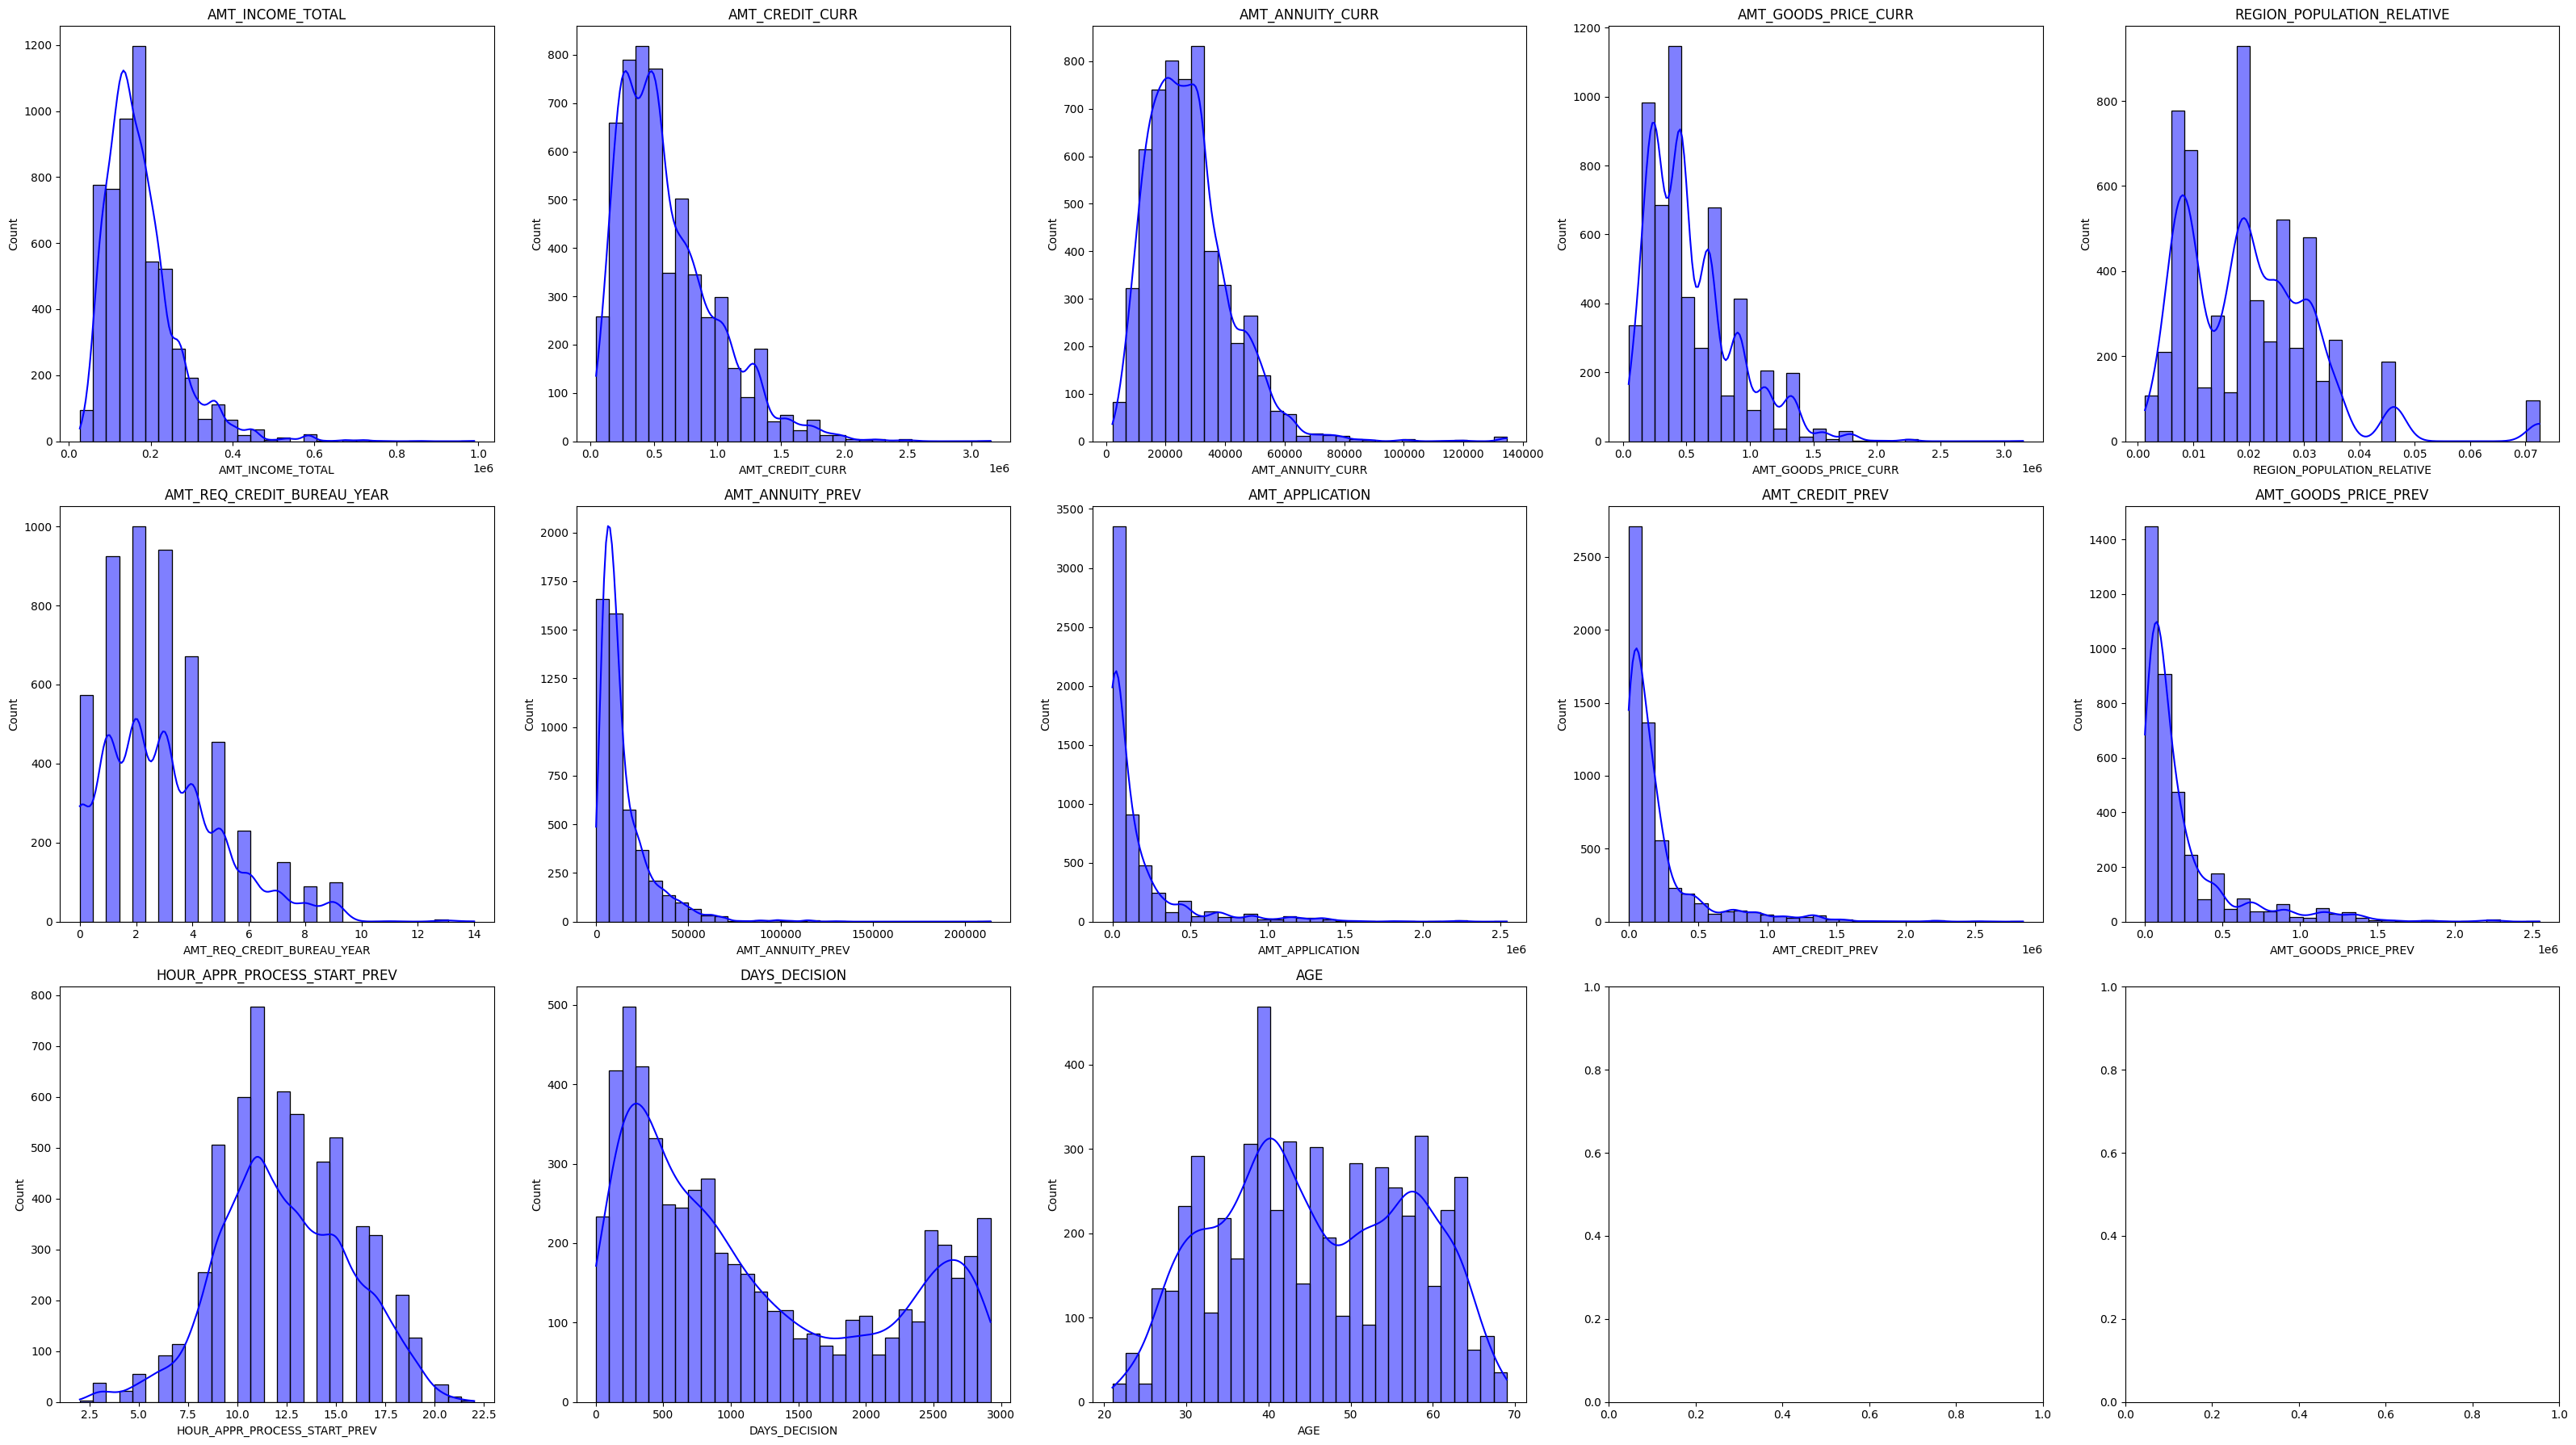

In [14]:
numfx = [
    'AMT_INCOME_TOTAL','AMT_CREDIT_CURR', 'AMT_ANNUITY_CURR',
    'AMT_GOODS_PRICE_CURR','REGION_POPULATION_RELATIVE','AMT_REQ_CREDIT_BUREAU_YEAR', 
    'AMT_ANNUITY_PREV', 'AMT_APPLICATION', 'AMT_CREDIT_PREV','AMT_GOODS_PRICE_PREV',
    'HOUR_APPR_PROCESS_START_PREV', 'DAYS_DECISION', 'AGE'
]

# Create a 4x5 grid of subplots distplot
fig, axs = plt.subplots(3, 5, figsize=(32, 18))

# for each group of 4 colummns
for i, column in enumerate(numfx):
    # Create a distplot for the appropriate subplot
    sns.histplot(tc[column], ax=axs[i//5, i%5], color='blue', kde=True, bins=30)
    axs[i//5, i%5].set_title(column)

plt.tight_layout()
plt.show()

**Interpretaton:**<br>
From the histogram plot above we can infer that most of the necessary numerical features are positively skewed

In [15]:
# columns = ctg.columns
# n = len(columns)

# fig, axs = plt.subplots(7, 4, figsize=(30, 30))

# for i in range(7):
#     for j in range(4):
#         if 4*i+j < n:  # Corrected this line
#             sns.countplot(x=columns[4*i+j], hue='TARGET', data=ctg, ax=axs[i, j])

# plt.tight_layout()
# plt.show()

### Good & Bad Clients Comparison by they Average Amount Application & Income

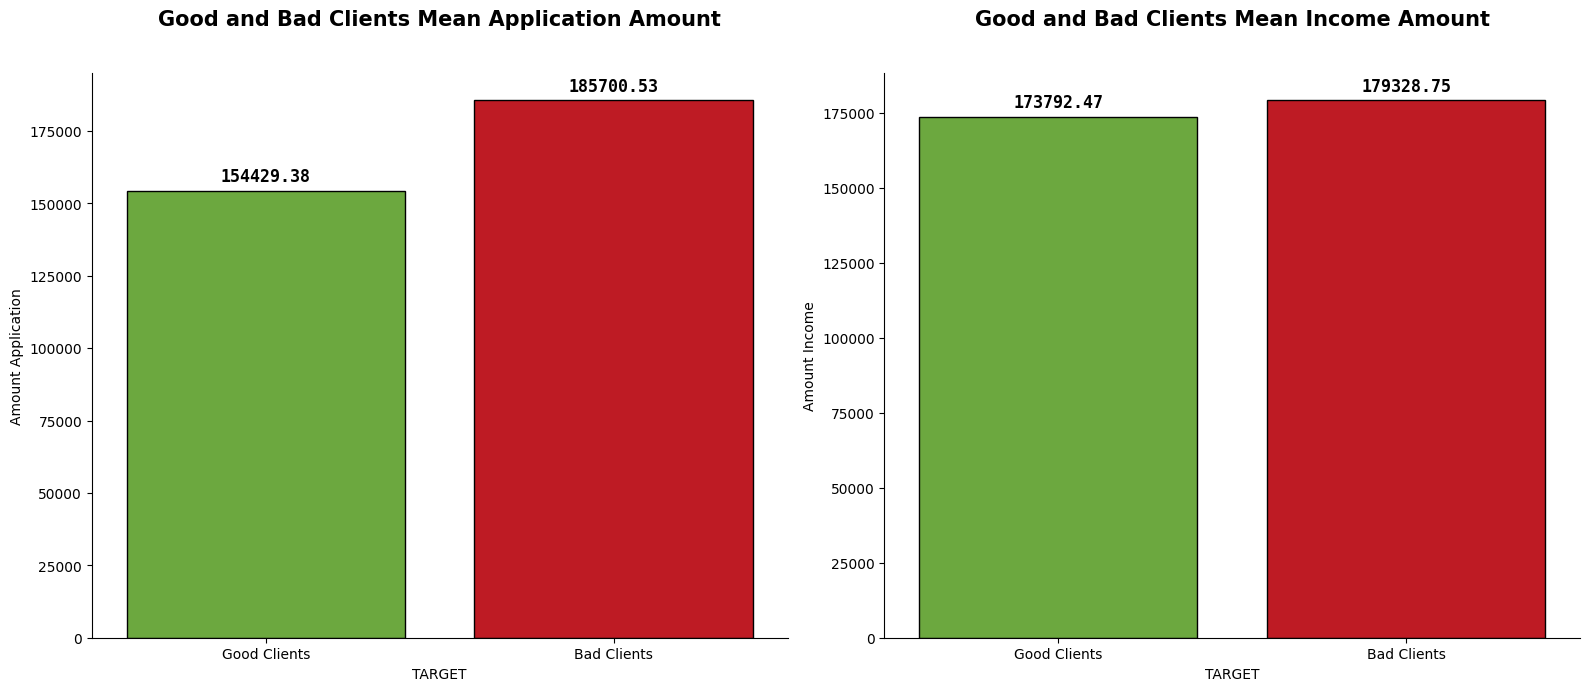

In [16]:
def create_plot(ax, data, x, y, title, ylabel):
    sns.barplot(x=x, y=y, data=data, ax=ax, palette=gbp, edgecolor='black')
    sns.despine()
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.07)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Good Clients', 'Bad Clients'])
    ax.set_ylabel(ylabel)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points',
                    fontweight='bold',
                    fontsize=12,
                    fontname='monospace')

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Group the data by 'TARGET' and calculate the mean of 'AMT_APPLICATION'
apl = tc.groupby('TARGET')['AMT_APPLICATION'].mean().reset_index(name='MEAN_APPLICATION')
create_plot(axes[0], apl, 'TARGET', 'MEAN_APPLICATION', 'Good and Bad Clients Mean Application Amount', 'Amount Application')

# Group the data by 'TARGET' and calculate the mean of 'AMT_INCOME_TOTAL'
mi = tc.groupby('TARGET')['AMT_INCOME_TOTAL'].mean().reset_index(name='MEAN_INCOME')
create_plot(axes[1], mi, 'TARGET', 'MEAN_INCOME', 'Good and Bad Clients Mean Income Amount', 'Amount Income')

# Finally, show the plot
plt.tight_layout()
plt.show()

**Interpretation** :<br>
There's no significance differences income between good clients and bad client, that mean the low income doesn't guarantee that the clients will be a bad clients.

### Good and Bad Clients Differences by Their Group Age

### Good and Bad Clients Differences by Their Group Age and Income

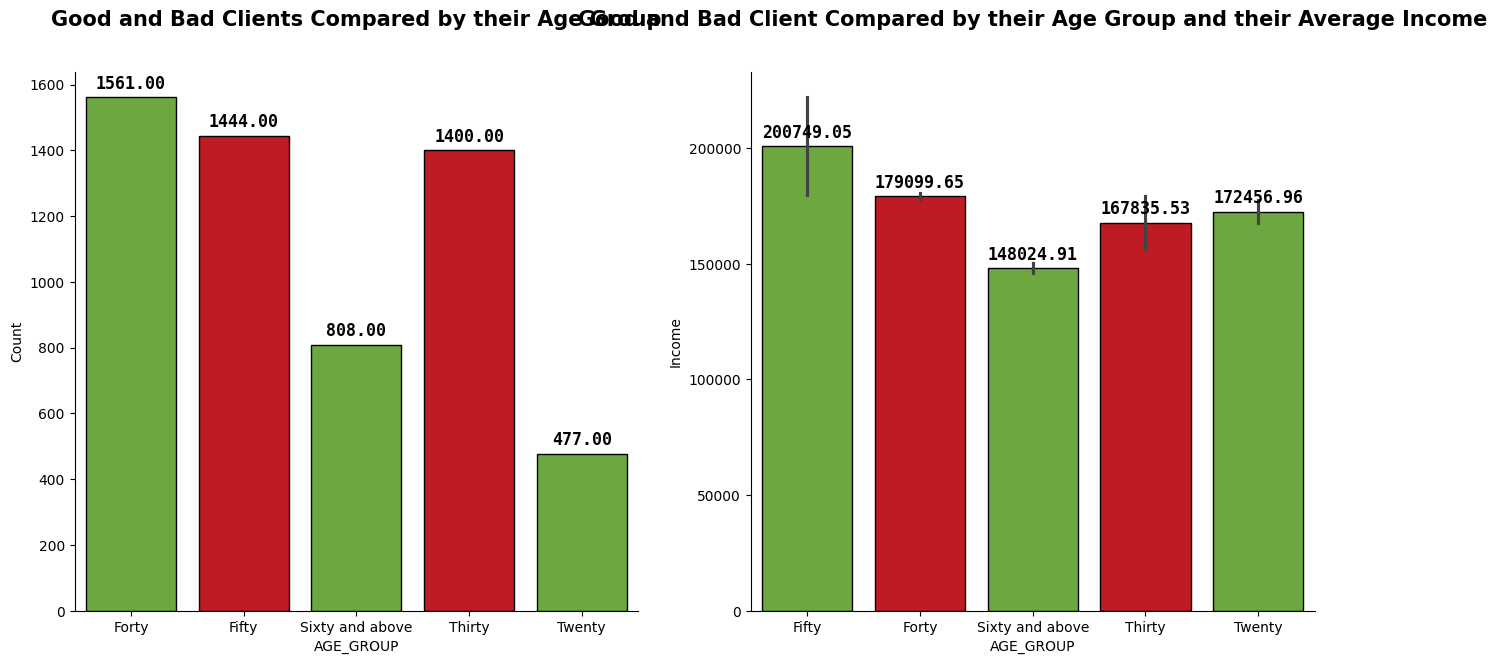

In [17]:
def create_plot(ax, data, x, y, title, ylabel):
    if y is None:
        sns.countplot(x=x, data=data, ax=ax, palette=gbp, edgecolor='black')
    else :
        sns.barplot(x=x, y=y, data=data, ax=ax, palette=gbp, edgecolor='black')
    
    sns.despine()
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.07)

    ax.set_ylabel(ylabel)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points',
                    fontweight='bold',
                    fontsize=12,
                    fontname='monospace')


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 
create_plot(axes[0], tc, 'AGE_GROUP', None, 'Good and Bad Clients Compared by their Age Group', 'Count')

agm = tc.groupby(['TARGET', 'AGE_GROUP'])['AMT_INCOME_TOTAL'].mean().reset_index(name='MEAN_INCOME')
create_plot(axes[1], agm, 'AGE_GROUP', 'MEAN_INCOME', 'Good and Bad Client Compared by their Age Group and their Average Income', 'Income')

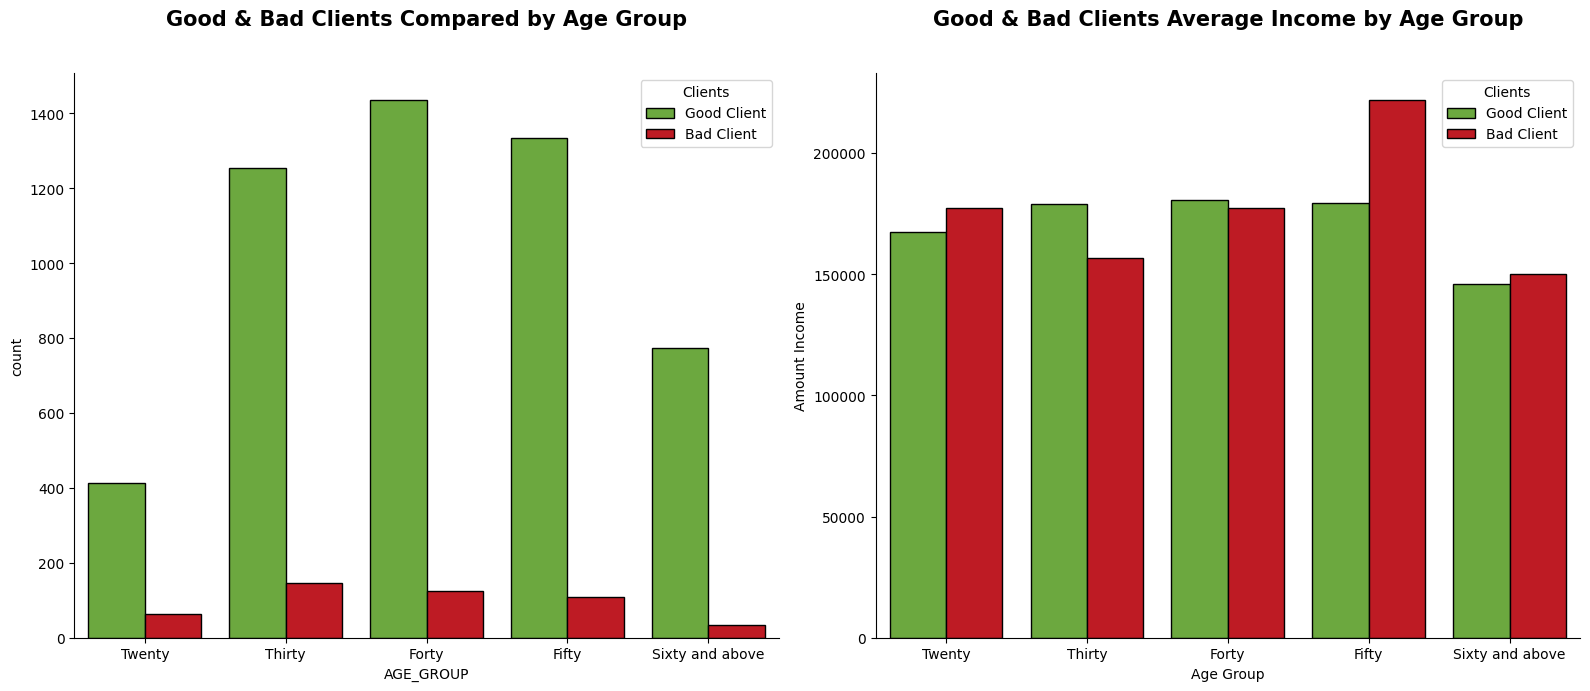

In [18]:
# Setting the figure size for the plots
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Creating a countplot for 'AGE_GROUP' with hue as 'TARGET'
countplot = sns.countplot(x='AGE_GROUP', data=tc, hue='TARGET', palette=gbp, order=age_labels, edgecolor='black', ax=axs[0])
# Setting the title for the countplot
countplot.set_title('Good & Bad Clients Compared by Age Group',  fontsize=15, fontweight='bold', y=1.07)

# Getting the legend from the countplot
legend = countplot.get_legend()
# Setting the title for the legend
legend.set_title("Clients")

# Updating the legend texts
for t, l in zip(legend.texts,("Good Client", "Bad Client")):
    t.set_text(l)

# Creating a barplot for 'AGE_GROUP' vs 'MEAN_INCOME' with hue as 'TARGET'
barplot = sns.barplot(x='AGE_GROUP', y='MEAN_INCOME', data=agm, hue='TARGET', palette=gbp, order=age_labels, edgecolor='black', ax=axs[1])
# Setting the title for the barplot
barplot.set_title('Good & Bad Clients Average Income by Age Group', fontsize=15, fontweight='bold', y=1.07)
# Setting the y-label for the barplot
barplot.set_ylabel('Amount Income')
# Setting the x-label for the barplot
barplot.set_xlabel('Age Group')

# Getting the legend from the barplot
legend = barplot.get_legend()
# Setting the title for the legend
legend.set_title("Clients")

# Updating the legend texts
for t, l in zip(legend.texts,("Good Client", "Bad Client")):
    t.set_text(l)

# Removing the top and right spines from plot
sns.despine()

# Adjusting the padding between and around the subplots
plt.tight_layout()

# Displaying the figure
plt.show()

<Axes: xlabel='AGE_GROUP', ylabel='AMT_CREDIT_CURR'>

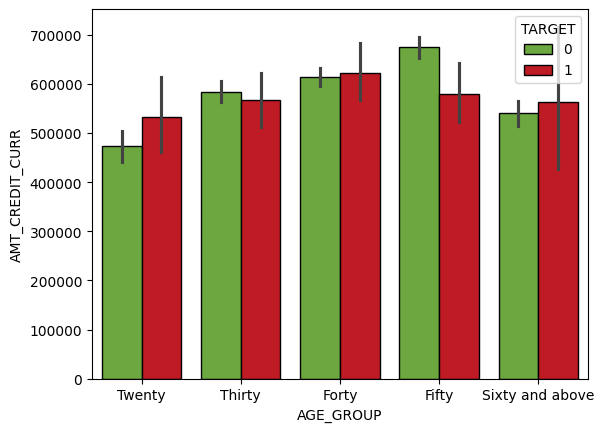

In [19]:
sns.barplot(x='AGE_GROUP', y='AMT_CREDIT_CURR', data=tc, hue='TARGET', palette=gbp, edgecolor='black', order=age_labels)

<Axes: xlabel='REGION_POPULATION_GROUP', ylabel='COUNT'>

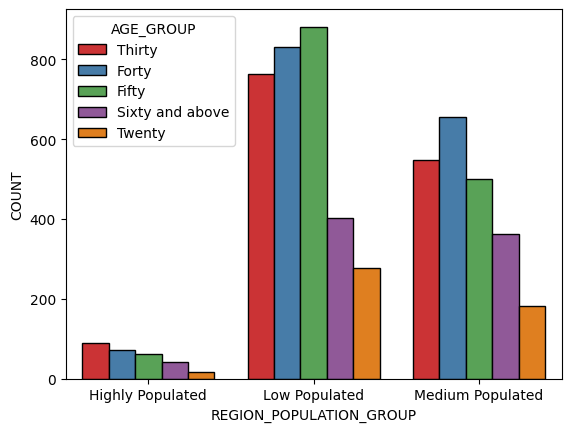

In [20]:
ap = tc.groupby(['REGION_POPULATION_GROUP'])['AGE_GROUP'].value_counts().reset_index(name='COUNT')
sns.barplot(x='REGION_POPULATION_GROUP', y='COUNT', data=ap, hue='AGE_GROUP', palette='Set1', edgecolor='black')

**Interpretation**<br>
Client with age of fifty with high income tend to have payment difficulties, we can see that the age of fifty is the highest age with payment difficulties, and the income is also high. This is interesting because we can see that the client with high income tend to have payment difficulties.

<Axes: xlabel='AGE_GROUP', ylabel='COUNT'>

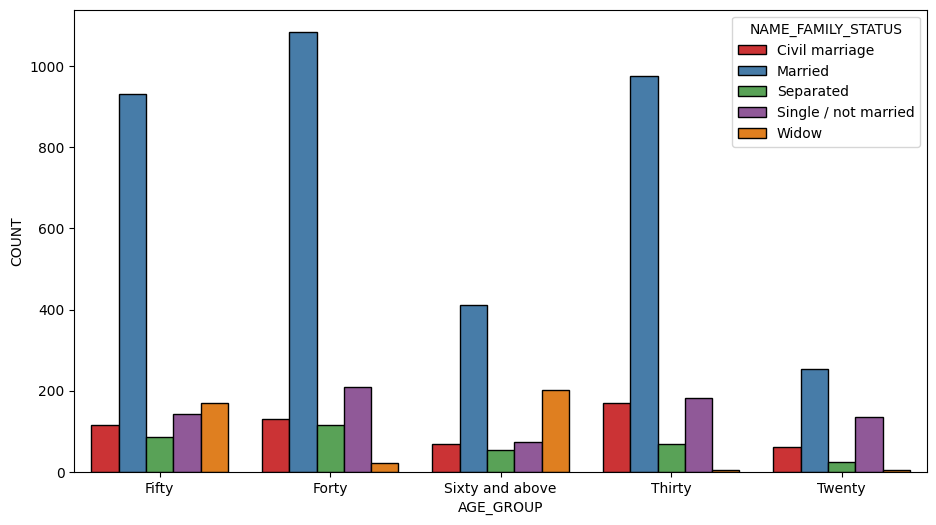

In [21]:
anc = tc.groupby(['AGE_GROUP', 'NAME_FAMILY_STATUS'])['SK_ID_CURR'].count().reset_index(name='COUNT')
plt.figure(figsize=(11, 6))
sns.barplot(x='AGE_GROUP', y='COUNT', data=anc, hue='NAME_FAMILY_STATUS', palette='Set1', edgecolor='black')

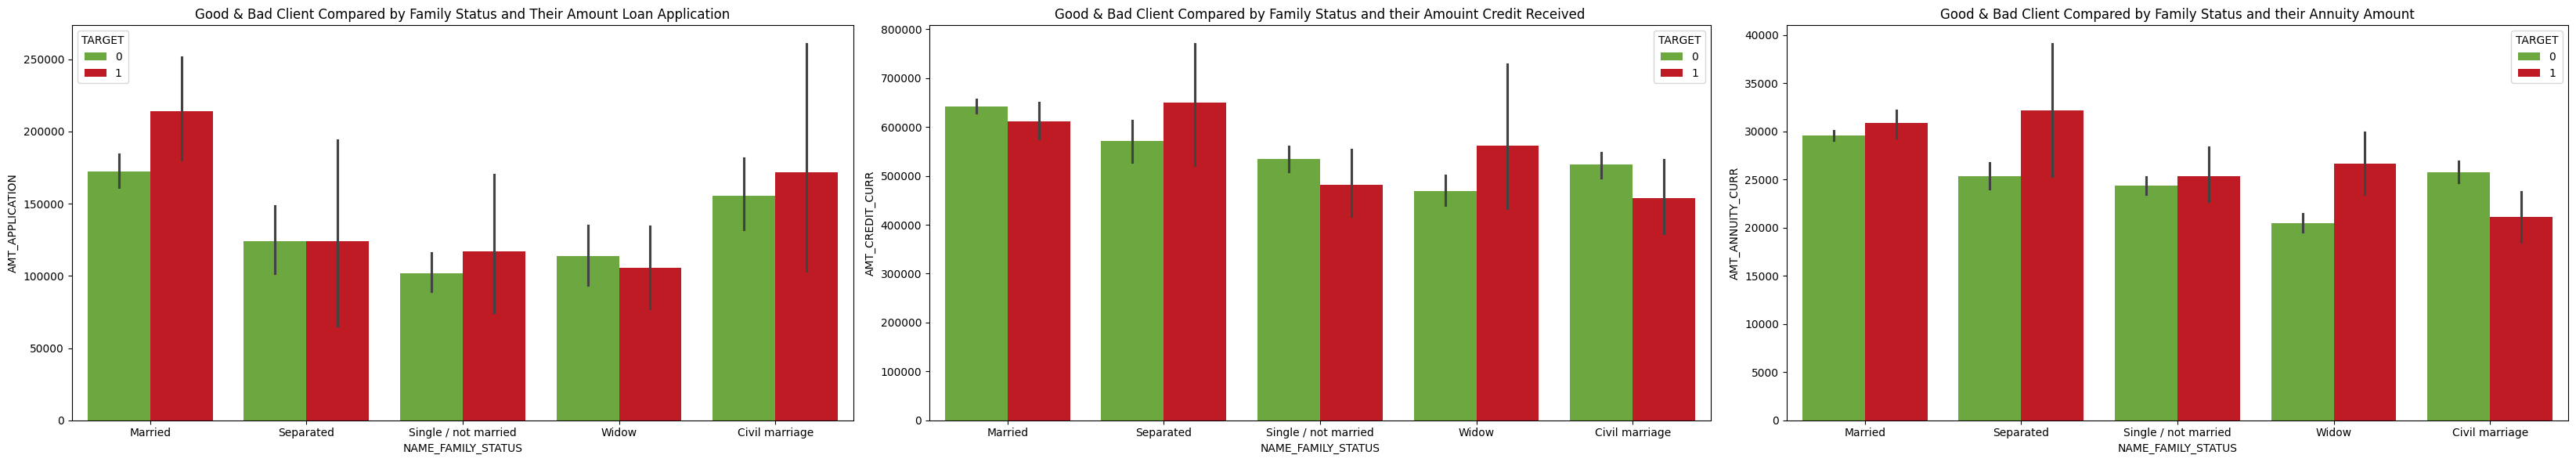

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(33, 6))

sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_APPLICATION', hue='TARGET', data=tc, palette=gbp, ax=axs[0])
axs[0].set_title('Good & Bad Client Compared by Family Status and Their Amount Loan Application')

sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_CREDIT_CURR', hue='TARGET', data=tc, palette=gbp, ax=axs[1])
axs[1].set_title('Good & Bad Client Compared by Family Status and their Amouint Credit Received')

sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_ANNUITY_CURR', hue='TARGET', data=tc, palette=gbp, ax=axs[2])
axs[2].set_title('Good & Bad Client Compared by Family Status and their Annuity Amount')

plt.tight_layout()
plt.show()

### Good & Bad Client Compared by The Children they Have

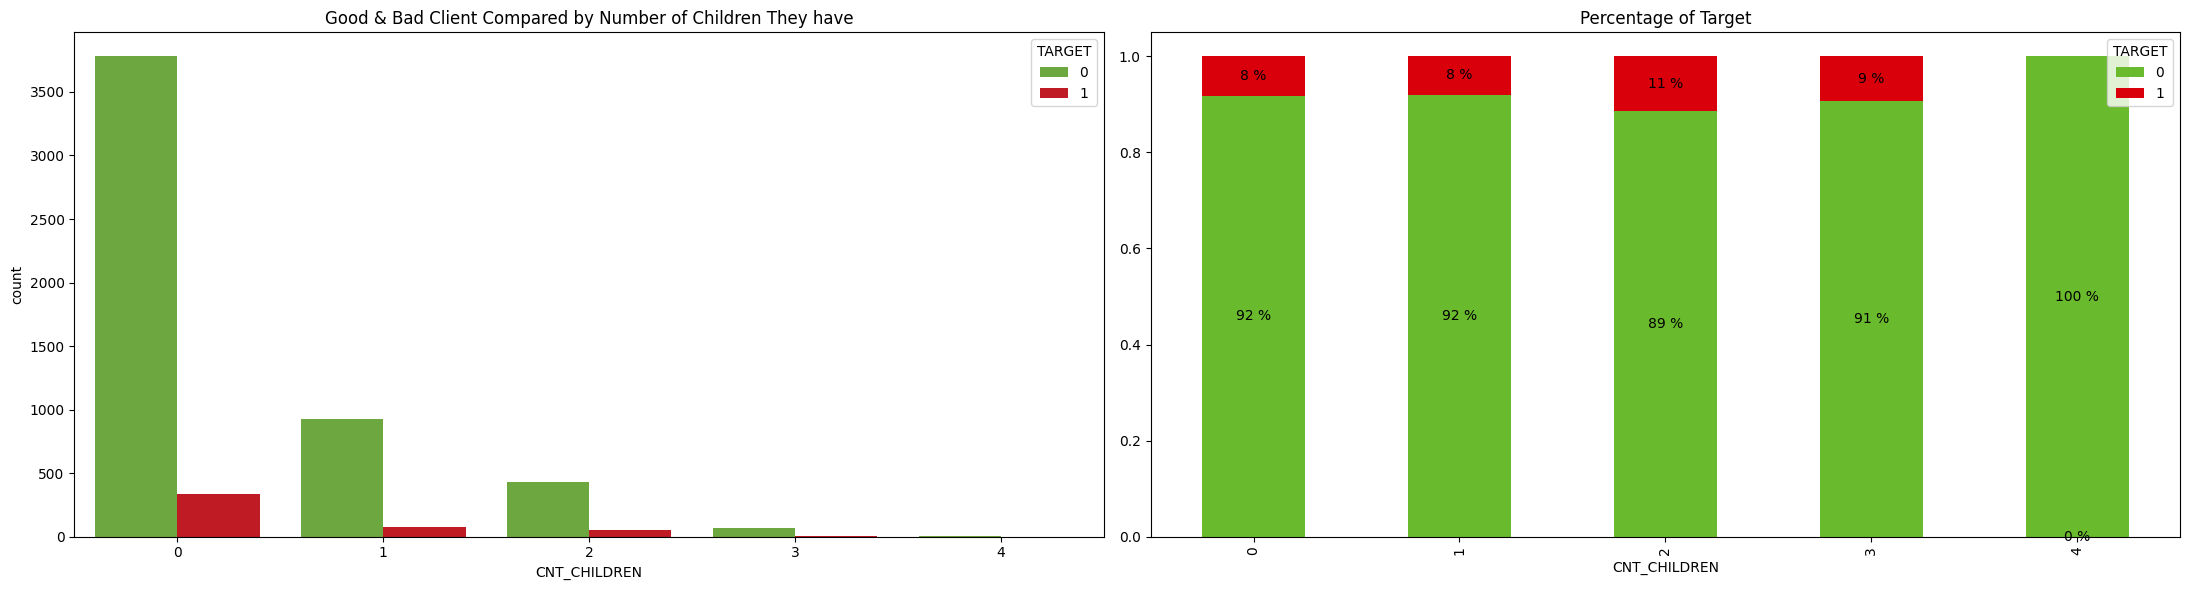

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(22, 6))

# plot 1
sns.countplot(x='CNT_CHILDREN', data=tc, hue='TARGET', palette=gbp, ax=axs[0])
axs[0].set_title('Good & Bad Client Compared by Number of Children They have')

# plot 2 (percentage)
counts = tc.groupby(['CNT_CHILDREN', 'TARGET']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0)

# create the stacekd bar chart
percentages.plot(kind='bar', stacked=True, color=gbp, ax=axs[1])
axs[1].set_title('Percentage of Target')

# add annotations
for p in axs[1].patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    axs[1].text(x+width/2,
                y+height/2, 
                '{:.0f} %'.format(height*100),
                horizontalalignment='center',
                verticalalignment='center')

plt.tight_layout()
plt.show()

<Axes: xlabel='AGE_GROUP', ylabel='LOAN'>

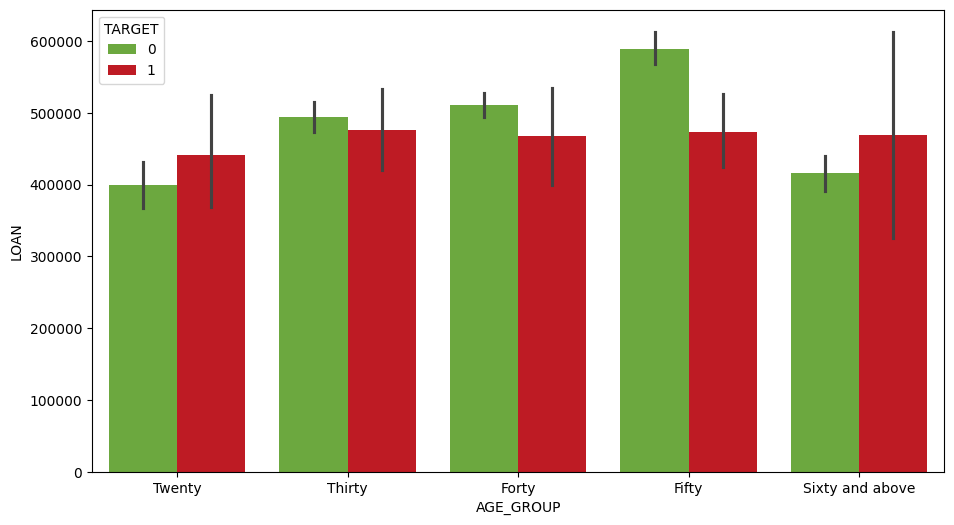

In [24]:
da = tc.copy()
da['LOAN'] = abs(da['AMT_APPLICATION'] - da['AMT_CREDIT_CURR'])

plt.figure(figsize=(11, 6))
sns.barplot(x='AGE_GROUP', y='LOAN', hue='TARGET', data=da, palette=gbp, order=age_labels)

<Axes: xlabel='NAME_FAMILY_STATUS', ylabel='AMT_ANNUITY_CURR'>

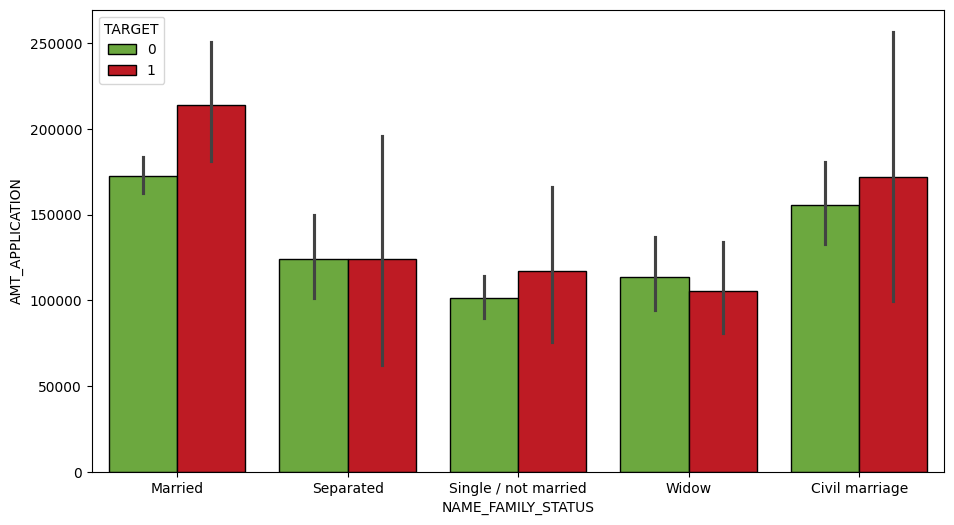

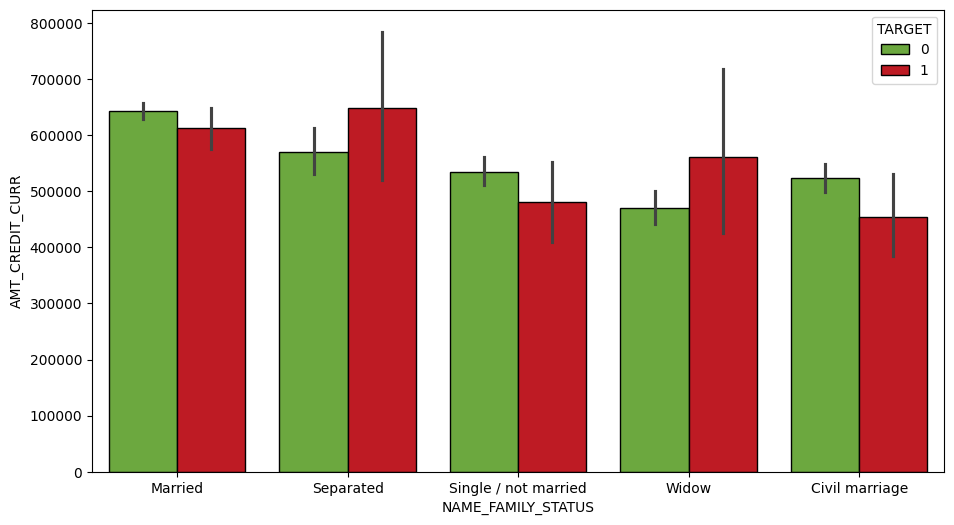

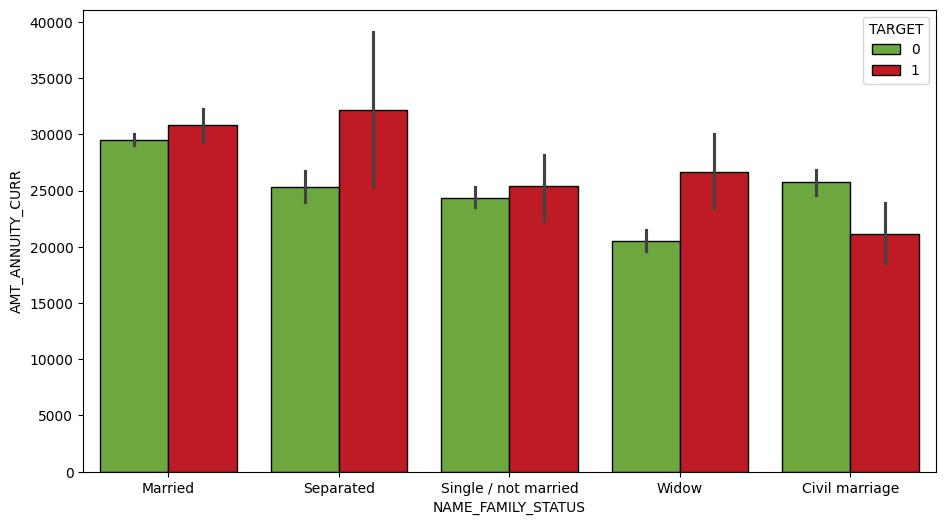

In [25]:
plt.figure(figsize=(11, 6))
sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_APPLICATION', hue='TARGET', data=tc, palette=gbp, edgecolor='black')

plt.figure(figsize=(11, 6))
sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_CREDIT_CURR', hue='TARGET', data=tc, palette=gbp, edgecolor='black')

plt.figure(figsize=(11, 6))
sns.barplot(x='NAME_FAMILY_STATUS', y='AMT_ANNUITY_CURR', hue='TARGET', data=tc, palette=gbp, edgecolor='black')

In [26]:
# nc = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_CURR', 'AMT_ANNUITY_CURR',
#       'REGION_POPULATION_RELATIVE', 'AMT_ANNUITY_PREV',
#       'AMT_APPLICATION', 'AMT_CREDIT_PREV', 'AMT_GOODS_PRICE_PREV']

# for i in nc:
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='AGE_GROUP', y=i, hue='TARGET', data=tc, palette=gbp, order=age_labels)

# # plt.figure(figsize=(11, 6))
# # sns.barplot(x='AGE_GROUP', y=i, hue='TARGET', data=tc, palette=gbp, order=age_labels)

<Axes: xlabel='NAME_FAMILY_STATUS', ylabel='count'>

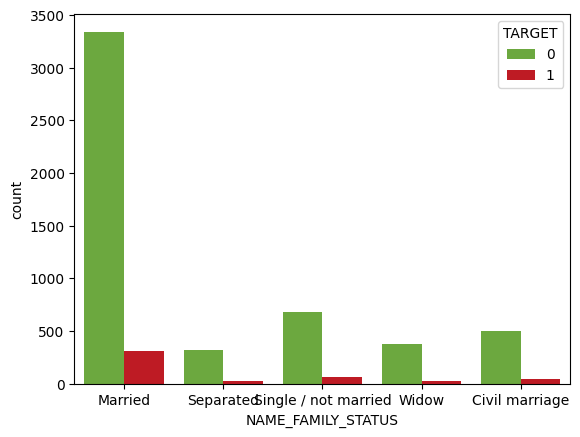

In [27]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=tc, palette=gbp)

### Good and Bad Clients Differences by their Cash Loan Purpose

<Axes: xlabel='count', ylabel='NAME_CASH_LOAN_PURPOSE'>

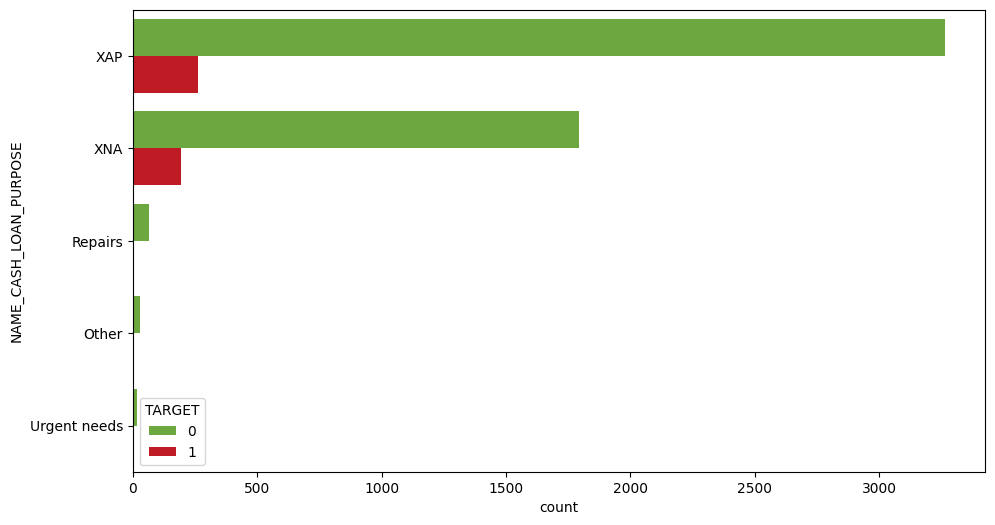

In [28]:
clp = tc.NAME_CASH_LOAN_PURPOSE.value_counts().head(5)

plt.figure(figsize=(11, 6))
sns.countplot(y='NAME_CASH_LOAN_PURPOSE', hue='TARGET', data=tc, palette=gbp, order=clp.index)

### Good and Bad Clients Differences by Their Current application and Previous Application of Contract Type

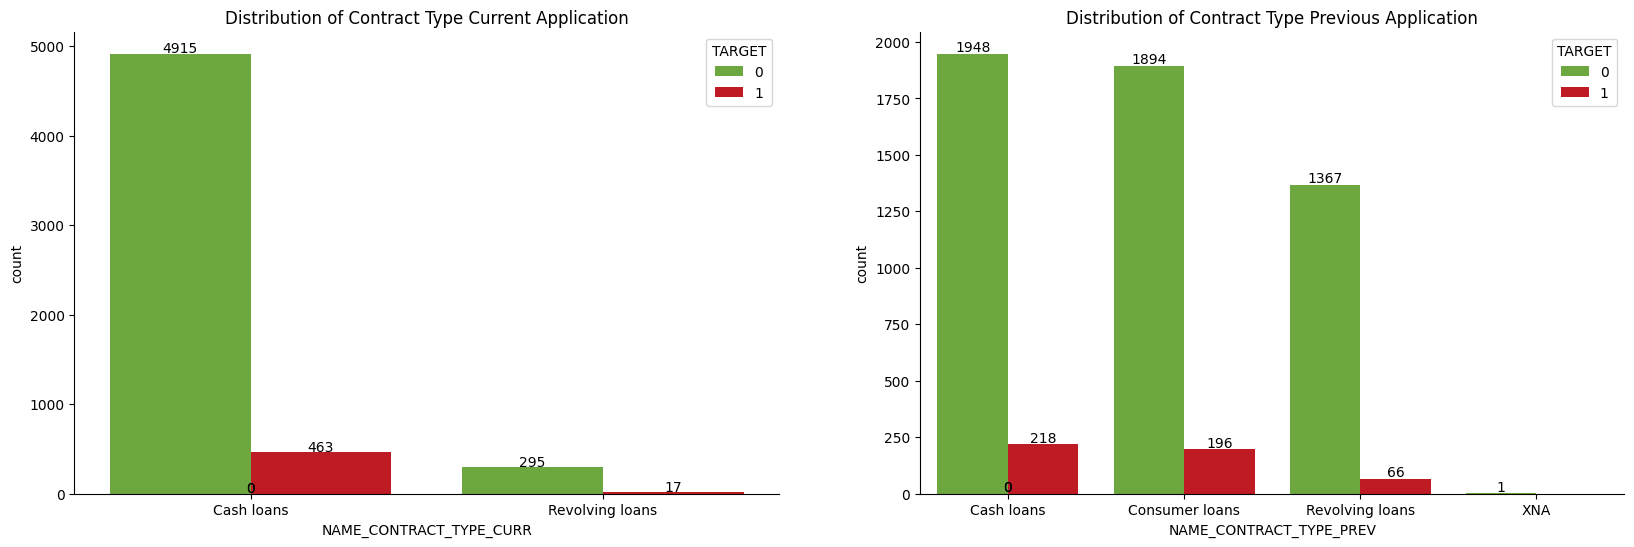

In [29]:
def annotate(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(x='NAME_CONTRACT_TYPE_CURR', data=tc, hue='TARGET', palette=gbp, ax=axs[0])
sns.despine()
axs[0].set_title('Distribution of Contract Type Current Application')
annotate(axs[0])

sns.countplot(x='NAME_CONTRACT_TYPE_PREV', data=tc, hue='TARGET', palette=gbp, ax=axs[1])
axs[1].set_title('Distribution of Contract Type Previous Application')
annotate(axs[1])

Client with payment difficulties tend to to 

### Bad Clients Differences by Their Region Population they Live

Text(0.5, 1.0, 'Bad Clients Region Population Relative Distribution')

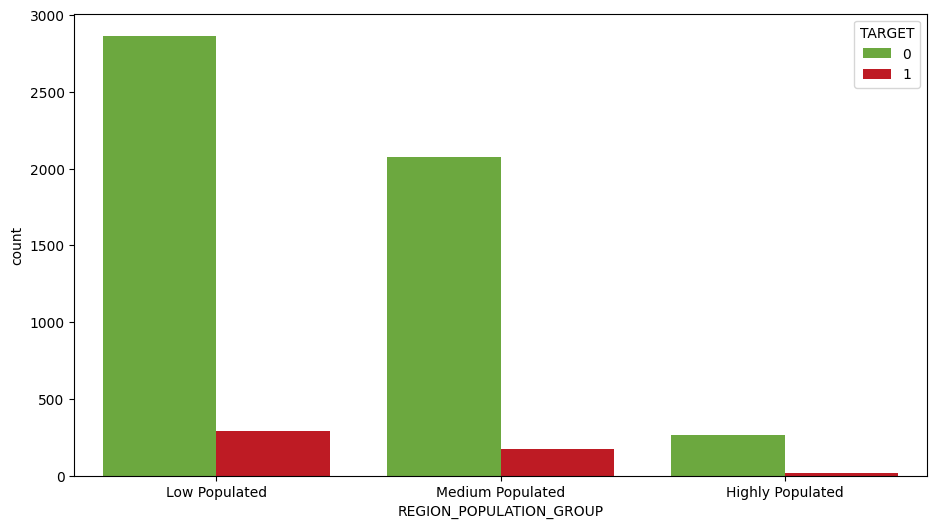

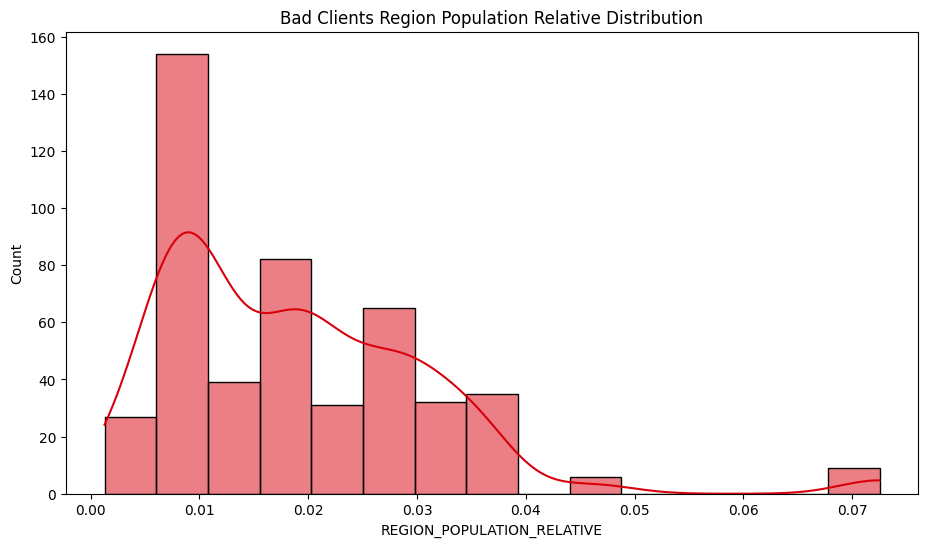

In [86]:
plt.figure(figsize=(11, 6))
sns.countplot(x='REGION_POPULATION_GROUP', data=tc, hue='TARGET', palette=gbp)


plt.figure(figsize=(11, 6))
good = tc.loc[tc['TARGET'] == 0]
bad = tc.loc[tc['TARGET'] == 1]

# sns.histplot(x='REGION_POPULATION_RELATIVE',data=good, bins=15, color='#69ba2d')
sns.histplot(x='REGION_POPULATION_RELATIVE',data=bad, bins=15, color='#d9000c', kde=True, label='Bad Clients')
plt.title('Bad Clients Region Population Relative Distribution')

**Insight** :<br>
as we can see on the histplot above that the more populated region the client lives, the more likely they will not have payment difficulties.

Text(0.5, 1.0, 'Bad Client Days Decision Distribution')

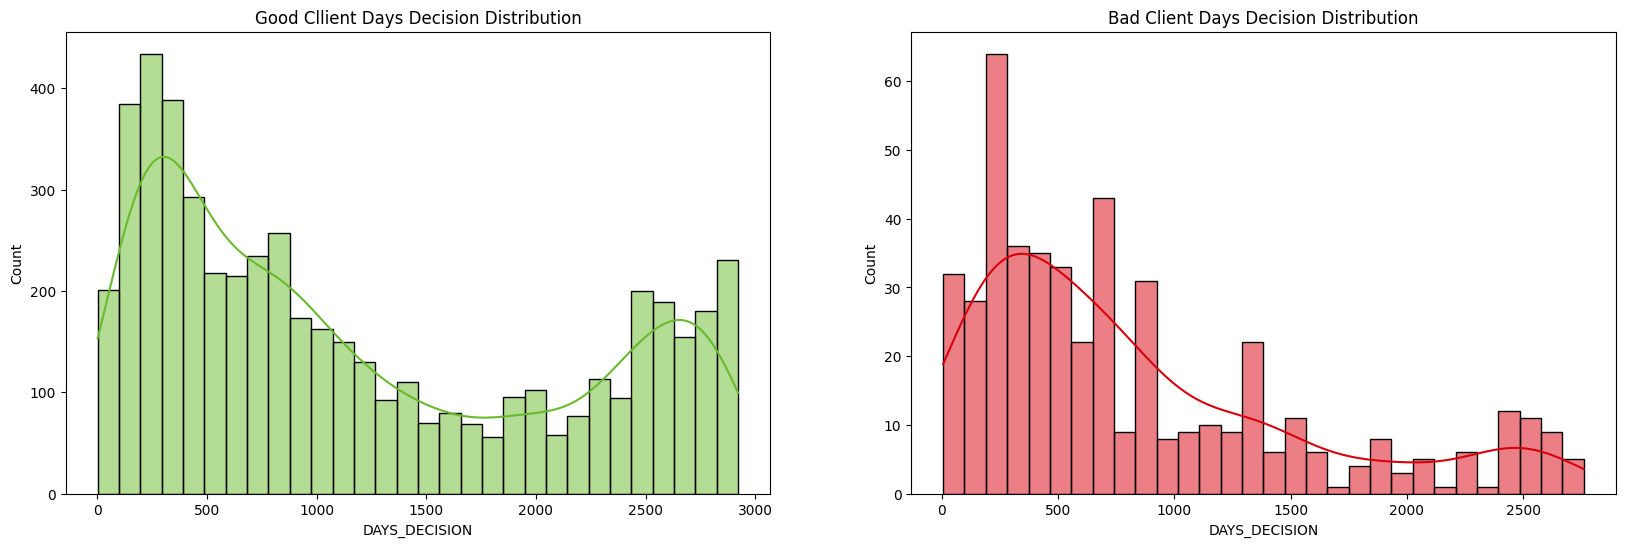

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(good['DAYS_DECISION'], color='#69ba2d', label='Good Clients', bins=30, kde=True, ax=axs[0])
axs[0].set_title('Good Cllient Days Decision Distribution')

sns.histplot(bad['DAYS_DECISION'], color='#d9000c', label='Bad Clients', bins=30, kde=True, ax=axs[1])
axs[1].set_title('Bad Client Days Decision Distribution')

From the 2 hisplot above we can infer that:
-  THe Good CLients

### Good and Bad Clients Differences by Their Decision Time  

<Axes: xlabel='YEAR_DECISION', ylabel='count'>

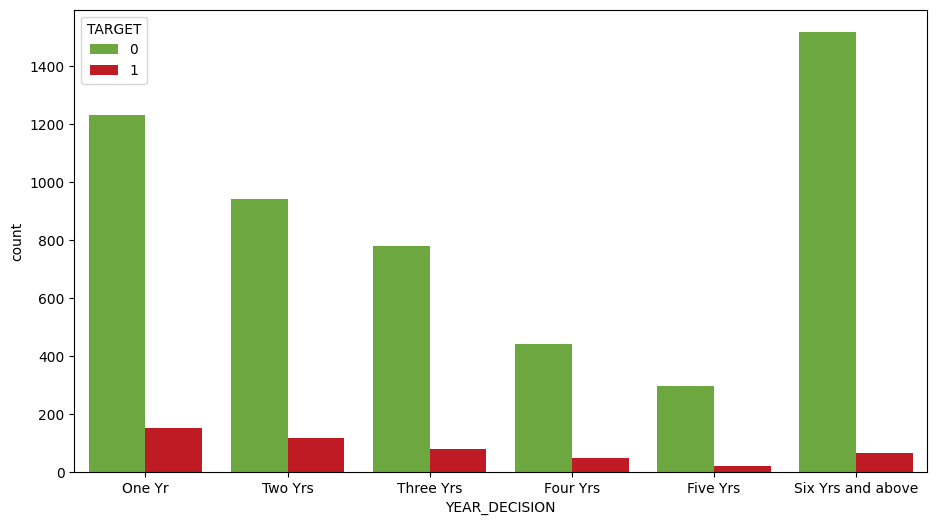

In [31]:
plt.figure(figsize=(11, 6))
sns.countplot(x='YEAR_DECISION', hue='TARGET', data=tc, palette=gbp, order=year_labels)

## Data Preprocessing
List of preprocessing to do:
- Handling Missing Values
- Handling Outliers
- Handling Imbalance Data


### Handle Missing Values

In [111]:
def impute_missing_values(data):
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        data[col].fillna(df[col].median(),inplace=True)
    for col in data.select_dtypes(include='object').columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    return data

tpc = tc.drop('TARGET', axis=1)
tp = impute_missing_values(tpc)
tp['TARGET'] = tc['TARGET']

mis = tp.isna().any().sum()
print(f'Total Missing Values in the Data Train: {mis}')


tsp = impute_missing_values(tsc)
mis = tsp.isna().any().sum()
print(f'Total Missing Values in the Data Test: {mis}')

Total Missing Values in the Data Train: 0
Total Missing Values in the Data Test: 0


### Handle Duplicated Data

In [ ]:
t

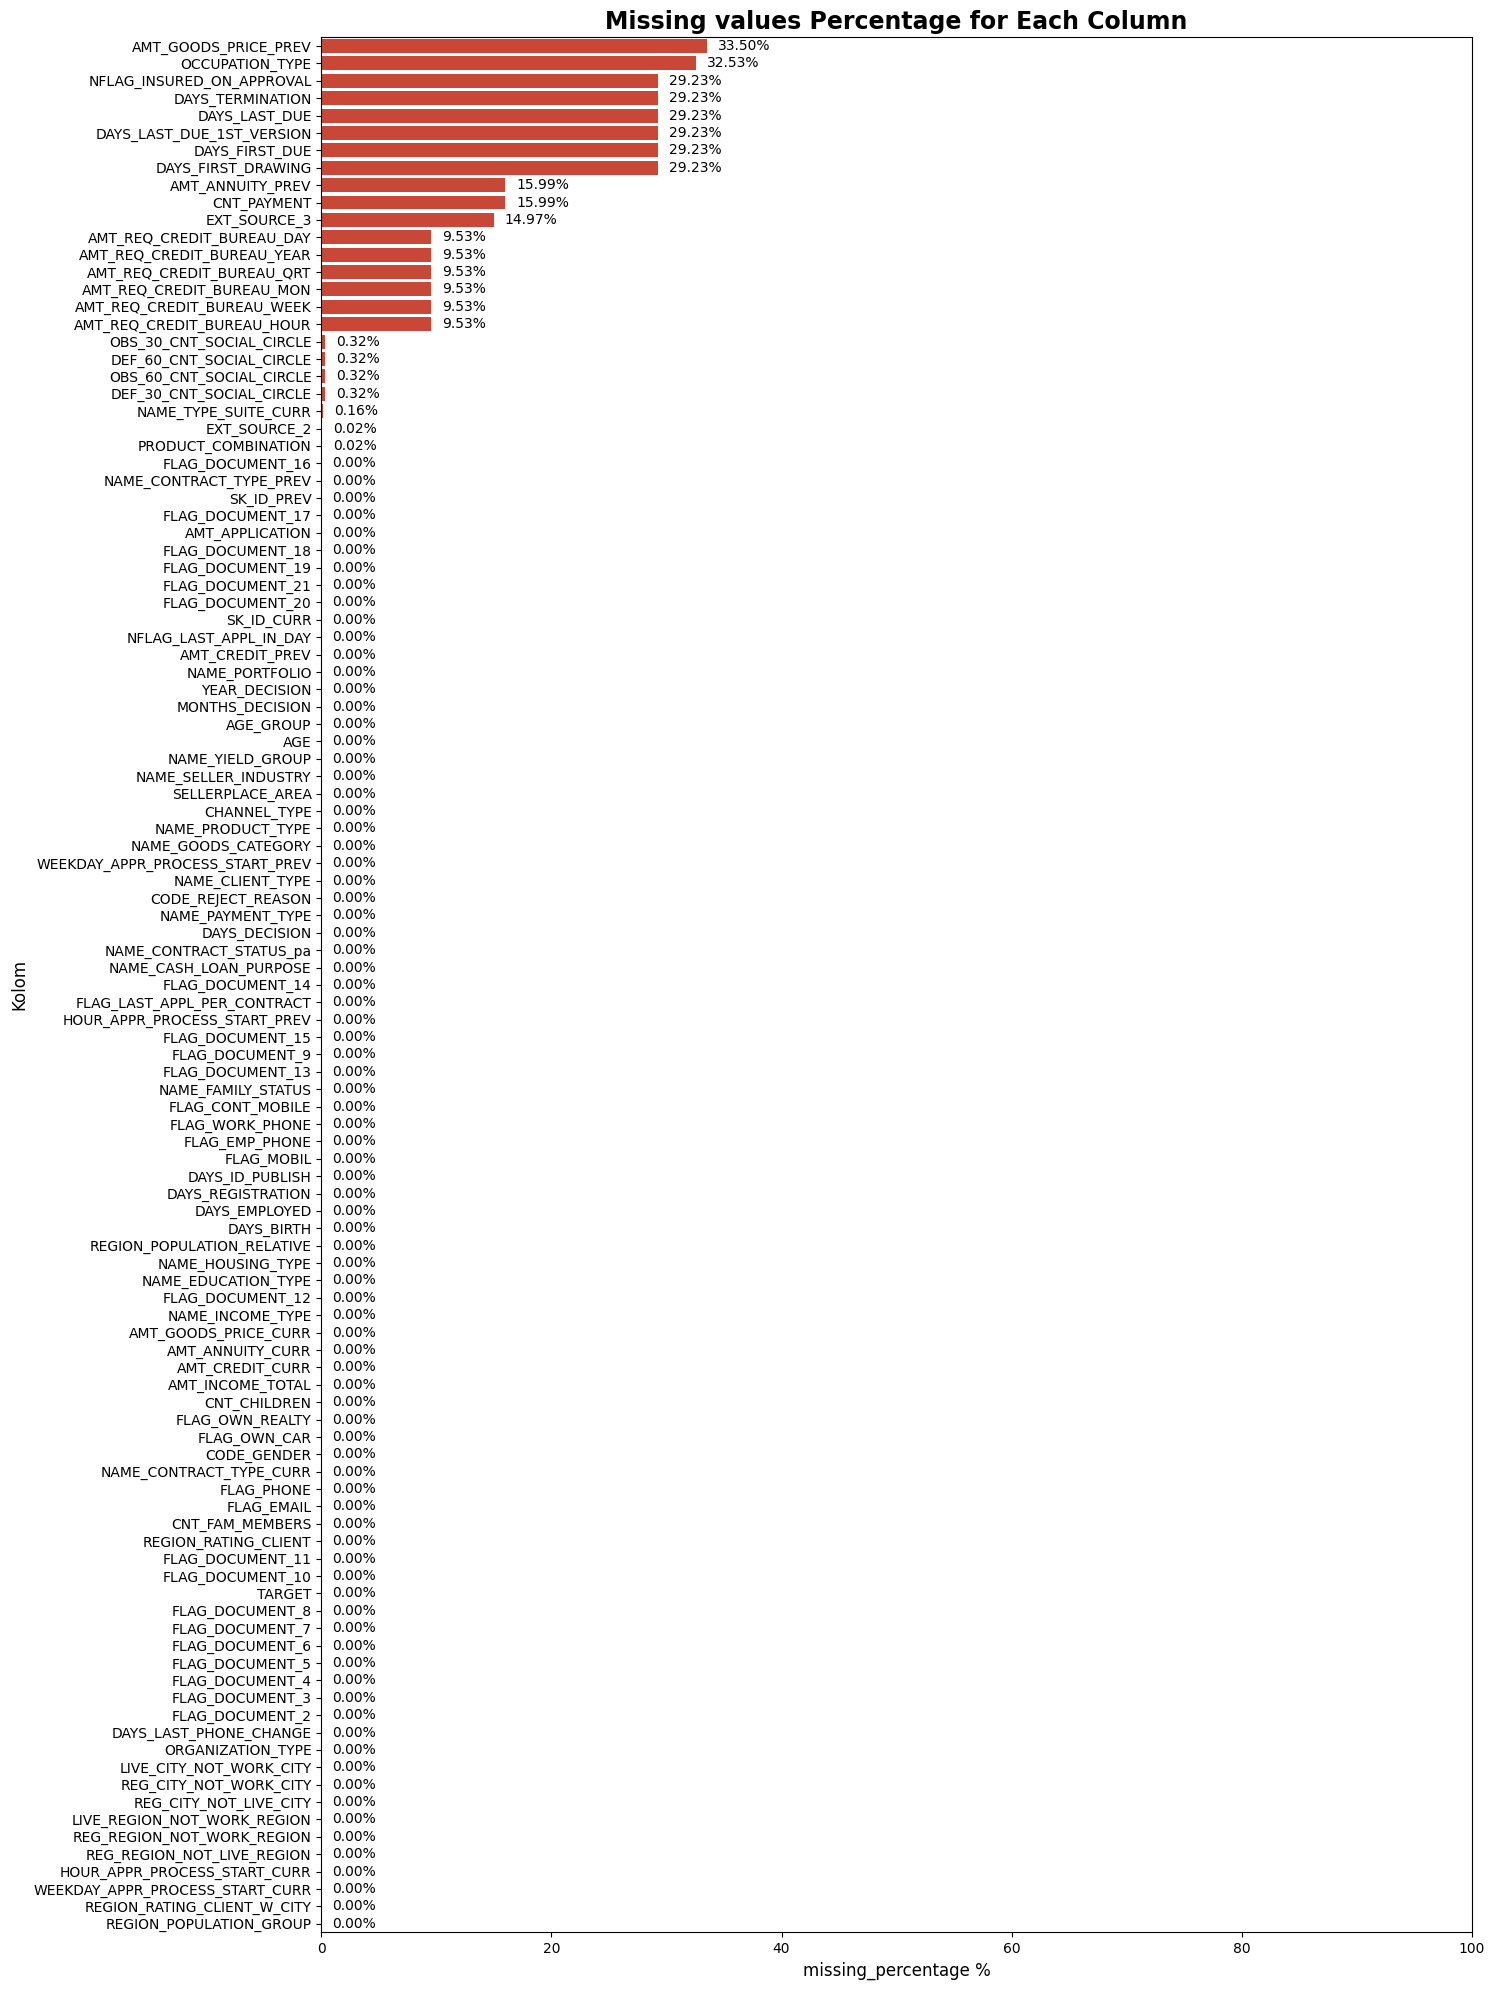

None

In [40]:
nan = tc[tc.isnull()]
# plot_missing_percentage(num)
display(plot_missing_percentage(tc))

## WOE (testing)

In [37]:
def cal_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
    
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    dset = dset.sort_values(by='WoE')

    return dset, iv


In [42]:
df, iv = cal_woe_iv(tc, 'AGE_GROUP', 'TARGET')
display(df)
print(iv)

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
4,Twenty,477,413,64,0.079271,0.133333,-0.519985,0.028112
3,Thirty,1400,1254,146,0.240691,0.304167,-0.234062,0.014857
0,Forty,1561,1436,125,0.275624,0.260417,0.056754,0.000863
1,Fifty,1444,1334,110,0.256046,0.229167,0.110908,0.002981
2,Sixty and above,808,773,35,0.148369,0.072917,0.710382,0.053600


0.10041284701629824


In [43]:
ctg.columns

Index(['NAME_CONTRACT_TYPE_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_CURR', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_CURR',
       'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE_PREV',
       'WEEKDAY_APPR_PROCESS_START_PREV', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS_pa',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'AGE_GROUP', 'YEAR_DECISION',
       'REGION_POPULATION_GROUP'],
      dtype='object')

In [44]:
df, iv = cal_woe_iv(tc, 'NAME_FAMILY_STATUS', 'TARGET')
display(df)
print(iv)

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
2,Single / not married,742,678,64,0.130134,0.133333,-0.024285,0.000078
0,Married,3656,3341,315,0.641267,0.656250,-0.023096,0.000346
1,Separated,346,317,29,0.060845,0.060417,0.007057,0.000003
4,Civil marriage,543,498,45,0.095585,0.093750,0.019389,0.000036
3,Widow,403,376,27,0.072169,0.056250,0.249203,0.003967


0.004429390540316268


-------

In [ ]:
# ctv = ctg[['NAME_CONTRACT_TYPE_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR',
#        'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_CURR', 'NAME_INCOME_TYPE',
#        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
#        'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE_PREV', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS_pa',
#        'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE',
#        'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
#        'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
#        'PRODUCT_COMBINATION']].copy()

# # Create a 6x4 grid of subplots of countplot
# fig, axs = plt.subplots(6, 4, figsize=(30, 30))

# # flatten the axes array
# axs = axs.flatten()

# # iterate over the column and create a countplot for each one
# for i, col in enumerate(ctv.columns):
#     sns.countplot(x=col, data=ctv, ax=axs[i], palette='hls')

# # remove the unused subplots
# for i in range(len(ctv.columns), len(axs)):
#     fig.delaxes(axs[i])

# plt.tight_layout()
# plt.show()


In [ ]:
# df2clean = [train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample]

# for i, df in enumerate(df2clean):
#     df2clean[i] = dropna(df)

# train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample = df2clean


In [ ]:
# # Merge data
# train_instllmnt = pd.merge(train_sample, ip_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ip'))
# train_cb = pd.merge(train_instllmnt, ccb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ccb'))
# train_pb = pd.merge(train_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')
# train_semi = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))

# # Train data
# train_full = pd.merge(train_semi, pa_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# test_full = pd.merge(test_sample, pa_sample, on='SK_ID_CURR', how='left')

In [ ]:
# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))

# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))

# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))

# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')


# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select necessary columns
# ip_sample = ip_sample.drop(columns='SK_ID_PREV')
# ccb_sample = ccb_sample.drop(columns='SK_ID_PREV')
# pb_sample = pb_sample.drop(columns='SK_ID_CURR')
# bb_sample = bb_sample.drop(columns='SK_ID_BUREAU')

# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))
# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))
# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')

# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select the columns you want from each dataframe excluding the identifier column
# ip_sample_selected = ip_sample.drop('SK_ID_PREV', axis=1)
# ccb_sample_selected = ccb_sample.drop('SK_ID_PREV', axis=1)
# pb_sample_selected = pb_sample.drop('SK_ID_CURR', axis=1)
# bureau_merge_selected = bureau_merge.drop('SK_ID_CURR', axis=1)

# # Merge the dataframes
# pa_instllmnt = pd.merge(pa_sample, ip_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_cb = pd.merge(pa_instllmnt, ccb_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_full = pd.merge(pa_cb, pb_sample_selected, left_on='SK_ID_CURR', right_index=True, how='left')

# # Select the columns you want from pa_full excluding the identifier column
# pa_full_selected = pa_full.drop('SK_ID_CURR', axis=1)

# # Merge with train_sample and test_sample
# train_semi = pd.merge(train_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# train_full = pd.merge(train_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')


# test_semi = pd.merge(test_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# test_full = pd.merge(test_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')